Loading cleaned dataset from: ./cleaned_agri_wages.csv
Original rows: 375913 cols: 10
Created 'wage_cat' from 'monthly_average_wage' with thresholds: low=200.00, high=300.00
After dropping NA in chosen cols, rows: 375913
Detected target classes: ['High', 'Low', 'Medium']
Saved encoder mappings to: ./outputs\encoder_mappings.txt

Classification report:

              precision    recall  f1-score   support

        High       0.71      0.46      0.56     20026
         Low       0.68      0.78      0.72     31182
      Medium       0.50      0.55      0.53     23975

    accuracy                           0.62     75183
   macro avg       0.63      0.60      0.60     75183
weighted avg       0.63      0.62      0.62     75183

Saved confusion matrix to: ./outputs\confusion_matrix.png
Saved decision tree to: ./outputs\decision_tree.png
Saved feature importances to: ./outputs\feature_importances.png

Top feature importances:
 year               0.434828
labour_type        0.280672
state_n

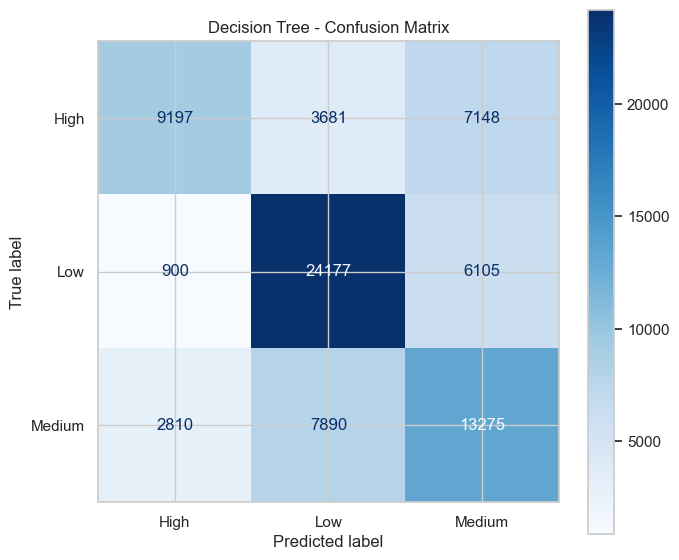

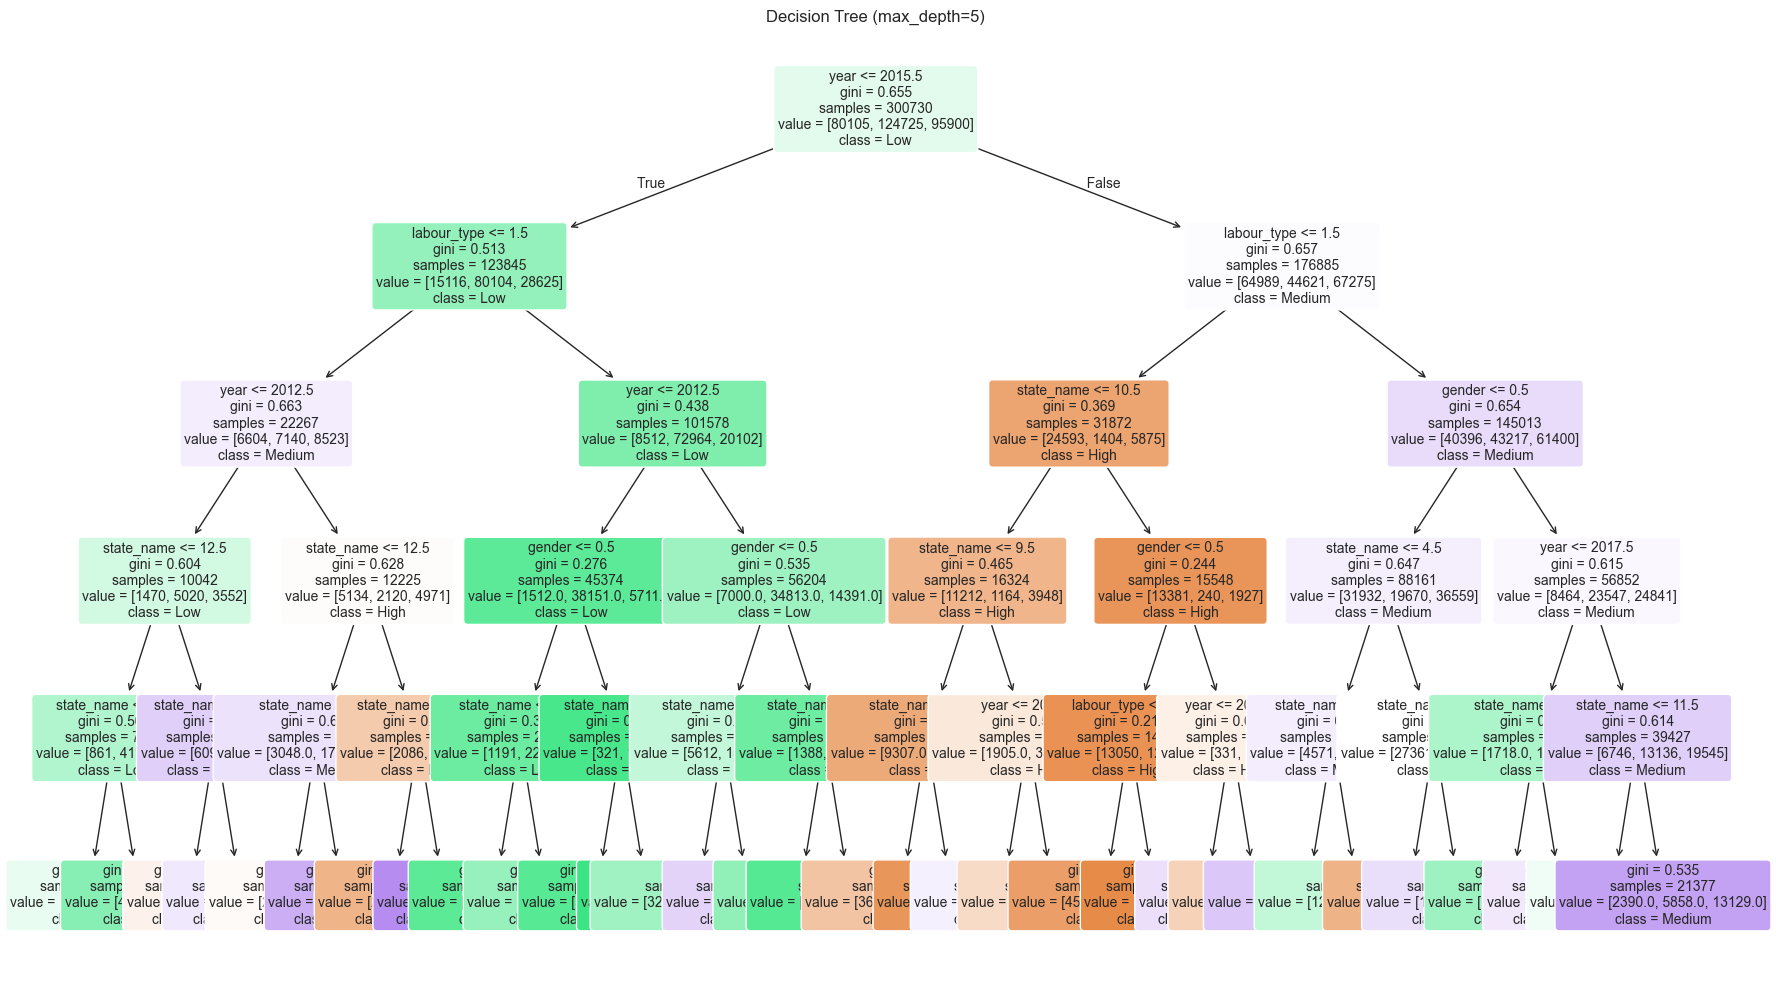

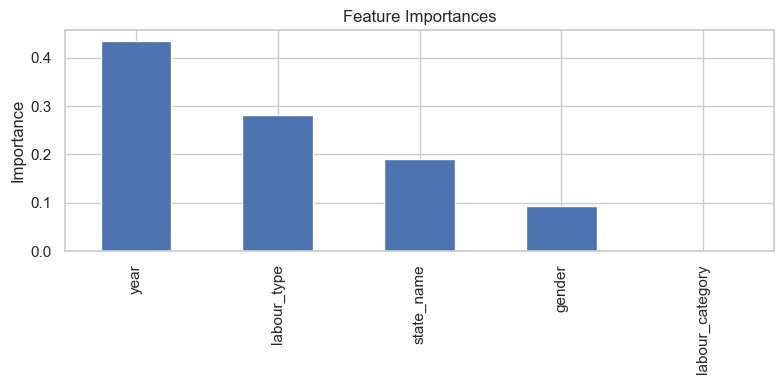

In [1]:
# decision_tree_cleaned_agri_wages.py
"""
Decision Tree pipeline for CLEANED agricultural wages dataset.
- Expects: ./cleaned_agri_wages.csv (edit FILE_PATH if different)
- Produces: classification report, confusion matrix, decision tree png,
            feature importances png, encoder mappings and class exemplars (plain English)
Run: python decision_tree_cleaned_agri_wages.py
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

sns.set(style="whitegrid")

# ---------- CONFIG ----------
FILE_PATH = "./cleaned_agri_wages.csv"   # point to your cleaned CSV
OUT_DIR = "./outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- HELPERS ----------
def ensure_wage_category(df, wage_col="monthly_average_wage", target_col="wage_cat"):
    """If wage_cat exists, keep it; else create Low/Medium/High using terciles."""
    if target_col in df.columns and df[target_col].notna().all():
        print(f"Using existing '{target_col}' column.")
        return df
    if wage_col not in df.columns:
        raise ValueError(f"Neither '{target_col}' nor '{wage_col}' found in dataset.")
    thr_low, thr_high = np.percentile(df[wage_col].dropna(), [33.33, 66.66])
    def map_fn(v):
        if v <= thr_low:
            return "Low"
        elif v <= thr_high:
            return "Medium"
        else:
            return "High"
    df[target_col] = df[wage_col].apply(map_fn)
    print(f"Created '{target_col}' from '{wage_col}' with thresholds: low={thr_low:.2f}, high={thr_high:.2f}")
    return df

def extract_year_safe(col):
    try:
        return pd.to_datetime(col, dayfirst=True, errors="coerce").year
    except Exception:
        try:
            return int(str(col)[-4:])
        except Exception:
            return np.nan

# ---------- 1. LOAD ----------
print("Loading cleaned dataset from:", FILE_PATH)
df = pd.read_csv(FILE_PATH)
print("Original rows:", df.shape[0], "cols:", df.shape[1])

# ---------- 2. TARGET ----------
df = ensure_wage_category(df, wage_col="monthly_average_wage", target_col="wage_cat")

# ---------- 3. FEATURE CHOICE ----------
# Choose interpretable features. Add or remove columns as your cleaned file provides.
# Common columns in your cleaned file: 'state_name', 'district_name', 'labour_category', 'labour_type', 'gender', 'month'
# We'll use a compact set to keep the tree readable; include district_name if you want more local splits.
features = ["state_name", "labour_category", "labour_type", "gender"]
# Extract year if month exists
if "month" in df.columns:
    df["year"] = df["month"].apply(extract_year_safe)
    features.append("year")

keep_cols = features + ["wage_cat"]
df_model = df[keep_cols].copy()
df_model = df_model.dropna()
print("After dropping NA in chosen cols, rows:", df_model.shape[0])

# ---------- 4. ENCODE ----------
encoders = {}
X = pd.DataFrame(index=df_model.index)
for col in features:
    if df_model[col].dtype == object or col == "year":
        if df_model[col].dtype == object:
            le = LabelEncoder()
            X[col] = le.fit_transform(df_model[col].astype(str))
            encoders[col] = le
        else:
            # Year -> numeric (int)
            X[col] = df_model[col].astype(int)
    else:
        X[col] = df_model[col]

y_le = LabelEncoder()
y = y_le.fit_transform(df_model["wage_cat"])
class_names = list(y_le.classes_)
print("Detected target classes:", class_names)

# Save encoder mappings (for report)
encoder_mappings = {}
for col, le in encoders.items():
    encoder_mappings[col] = {int(i): label for i, label in enumerate(le.classes_)}
# class mapping
class_mapping = {int(i): label for i, label in enumerate(y_le.classes_)}

# Persist mappings
mappings_path = os.path.join(OUT_DIR, "encoder_mappings.txt")
with open(mappings_path, "w", encoding="utf-8") as f:
    f.write("Encoder mappings (feature -> {code:label}):\n\n")
    for col, mapping in encoder_mappings.items():
        f.write(f"{col}: {mapping}\n")
    f.write("\nTarget class mapping:\n")
    f.write(str(class_mapping) + "\n")
print("Saved encoder mappings to:", mappings_path)

# ---------- 5. SPLIT ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ---------- 6. TRAIN ----------
clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, random_state=42)
clf.fit(X_train, y_train)

# ---------- 7. EVALUATE ----------
y_pred = clf.predict(X_test)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig_cm, ax_cm = plt.subplots(figsize=(7,6))
disp.plot(ax=ax_cm, cmap="Blues", values_format="d")
ax_cm.set_title("Decision Tree - Confusion Matrix")
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
fig_cm.savefig(cm_path, dpi=150, bbox_inches="tight")
print("Saved confusion matrix to:", cm_path)

# ---------- 8. VISUALIZE TREE ----------
fig_tree, ax_tree = plt.subplots(figsize=(18,10))
plot_tree(clf, feature_names=X.columns, class_names=class_names, filled=True, rounded=True, fontsize=10, ax=ax_tree)
ax_tree.set_title("Decision Tree (max_depth=5)")
plt.tight_layout()
tree_path = os.path.join(OUT_DIR, "decision_tree.png")
fig_tree.savefig(tree_path, dpi=150, bbox_inches="tight")
print("Saved decision tree to:", tree_path)

# ---------- 9. FEATURE IMPORTANCE ----------
fi = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
fig_fi, ax_fi = plt.subplots(figsize=(8,4))
fi.plot.bar(ax=ax_fi)
ax_fi.set_title("Feature Importances")
ax_fi.set_ylabel("Importance")
plt.tight_layout()
fi_path = os.path.join(OUT_DIR, "feature_importances.png")
fig_fi.savefig(fi_path, dpi=150, bbox_inches="tight")
print("Saved feature importances to:", fi_path)
print("\nTop feature importances:\n", fi.to_string())

# ---------- 10. EXPORT TEXT RULES ----------
rules_text = export_text(clf, feature_names=list(X.columns))
rules_path = os.path.join(OUT_DIR, "decision_rules.txt")
with open(rules_path, "w", encoding="utf-8") as f:
    f.write("Decision Tree textual rules (max_depth=5)\n\n")
    f.write(rules_text)
print("Saved textual rules to:", rules_path)

# ---------- 11. PLAIN-ENGLISH EXEMPLARS (human-friendly) ----------
# For each predicted class, show 5 representative examples from X_test that the model predicted as that class,
# showing original (decoded) feature values. This gives actionable, interpretable 'rules by example'.
exemplars_path = os.path.join(OUT_DIR, "class_exemplars.txt")
with open(exemplars_path, "w", encoding="utf-8") as f:
    f.write("Representative exemplars for each predicted wage class (decoded features):\n\n")
    X_test_orig = X_test.copy()
    # decode encoded categorical features to original labels where possible
    for col, le in encoders.items():
        X_test_orig[col] = le.inverse_transform(X_test[col].astype(int))
    # keep numeric year as-is
    preds = clf.predict(X_test)
    X_test_orig = X_test_orig.reset_index(drop=True)
    preds = pd.Series(preds, index=X_test_orig.index)
    df_ex = X_test_orig.copy()
    df_ex["pred_class_code"] = preds
    df_ex["pred_class"] = df_ex["pred_class_code"].map(class_mapping)
    # Save a handful of representative rows per class
    for cls_code, cls_name in class_mapping.items():
        f.write(f"--- Predicted class: {cls_name} ---\n")
        subset = df_ex[df_ex["pred_class_code"] == cls_code]
        if subset.shape[0] == 0:
            f.write("No examples predicted for this class in test set.\n\n")
            continue
        # Sample up to 5 examples (choose ones representative via value_counts)
        # Prefer the most common combinations
        comb_counts = subset.groupby(features).size().reset_index(name="count").sort_values("count", ascending=False)
        top_examples = comb_counts.head(5)
        for _, row in top_examples.iterrows():
            desc = ", ".join([f"{col}={row[col]}" for col in features])
            f.write(f"* {desc}  (count in test subset: {int(row['count'])})\n")
        f.write("\n")
print("Saved class exemplars to:", exemplars_path)
print("\nAll outputs saved in folder:", OUT_DIR)

# ---------- 12. Quick on-screen tips ----------
print("\nTip: Open the files in the outputs folder to include visuals in your report:")
print(" - decision_tree.png")
print(" - feature_importances.png")
print(" - confusion_matrix.png")
print(" - decision_rules.txt")
print(" - encoder_mappings.txt")
print(" - class_exemplars.txt")


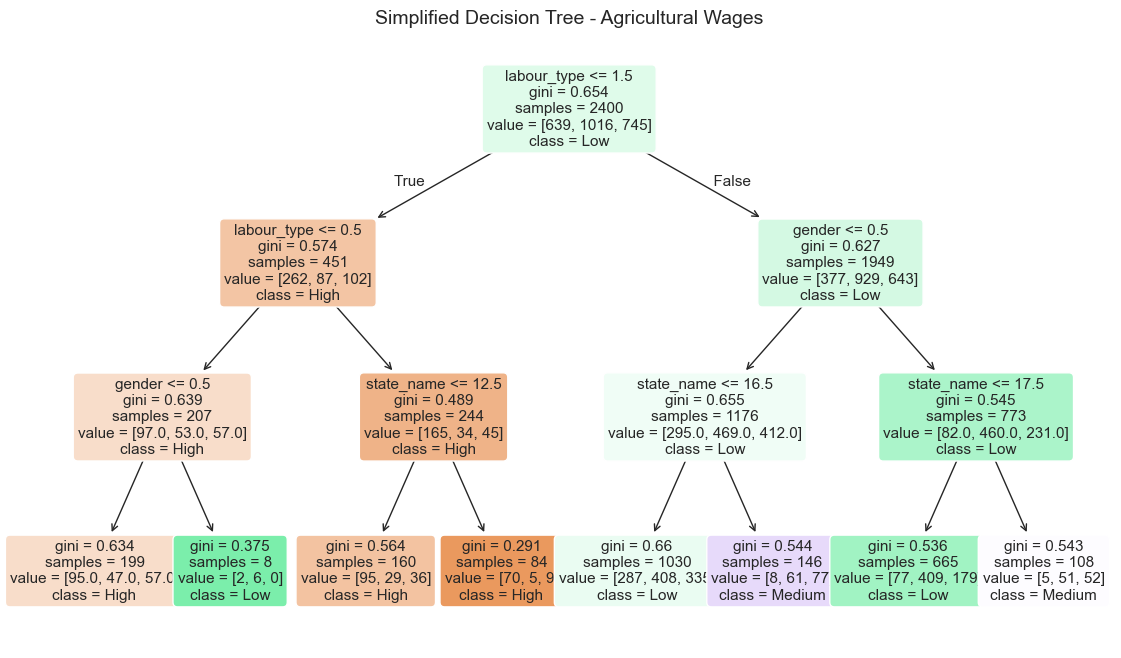


Saved clear tree as: simple_decision_tree_visible.png


<Figure size 640x480 with 0 Axes>

In [2]:
# SIMPLE AND CLEAR DECISION TREE (EASY TO VISUALIZE)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# ---------- Load cleaned dataset ----------
df = pd.read_csv("cleaned_agri_wages.csv")

# ---------- Create wage category (Low, Medium, High) ----------
low_thr, high_thr = np.percentile(df["monthly_average_wage"], [33.3, 66.6])

def wage_group(x):
    if x <= low_thr:
        return "Low"
    elif x <= high_thr:
        return "Medium"
    else:
        return "High"

df["wage_cat"] = df["monthly_average_wage"].apply(wage_group)

# ---------- Use only the most important columns ----------
# Fewer features = simpler tree
features = ["gender", "labour_type", "state_name"]
target = "wage_cat"
df = df[features + [target]].dropna()

# ---------- Encode text data ----------
le_dict = {}
for col in features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

y_le = LabelEncoder()
df[target] = y_le.fit_transform(df[target])

# ---------- (Optional) Sample smaller data for visibility ----------
df_sample = df.sample(n=3000, random_state=42)  # pick 3k rows only
X = df_sample[features]
y = df_sample[target]

# ---------- Split and train ----------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = DecisionTreeClassifier(max_depth=3, random_state=42)  # max_depth=3 for clarity
tree.fit(X_train, y_train)

# ---------- Plot a simpler, visible tree ----------
plt.figure(figsize=(14, 8))
plot_tree(
    tree,
    feature_names=features,
    class_names=y_le.classes_,
    filled=True,
    rounded=True,
    fontsize=11
)
plt.title("Simplified Decision Tree - Agricultural Wages", fontsize=14)
plt.show()

# ---------- Save image ----------
plt.savefig("simple_decision_tree_visible.png", dpi=150, bbox_inches="tight")
print("\nSaved clear tree as: simple_decision_tree_visible.png")


Rows after dropna: 375913
Created wage_cat with thresholds low=200.00, high=300.00


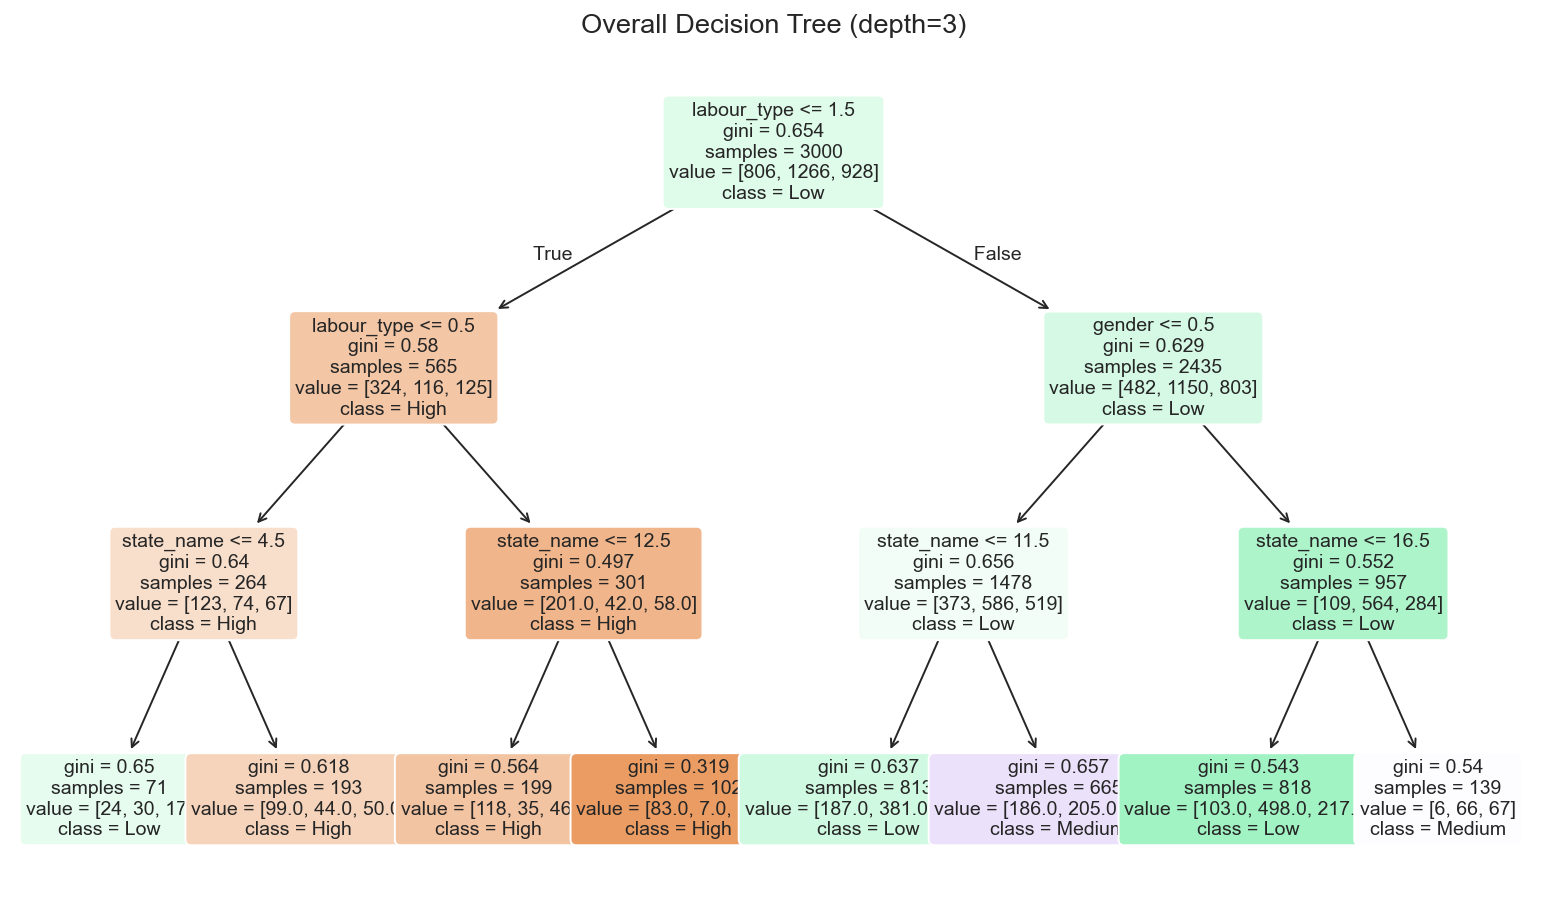


🌿 Showing tree for gender: Men


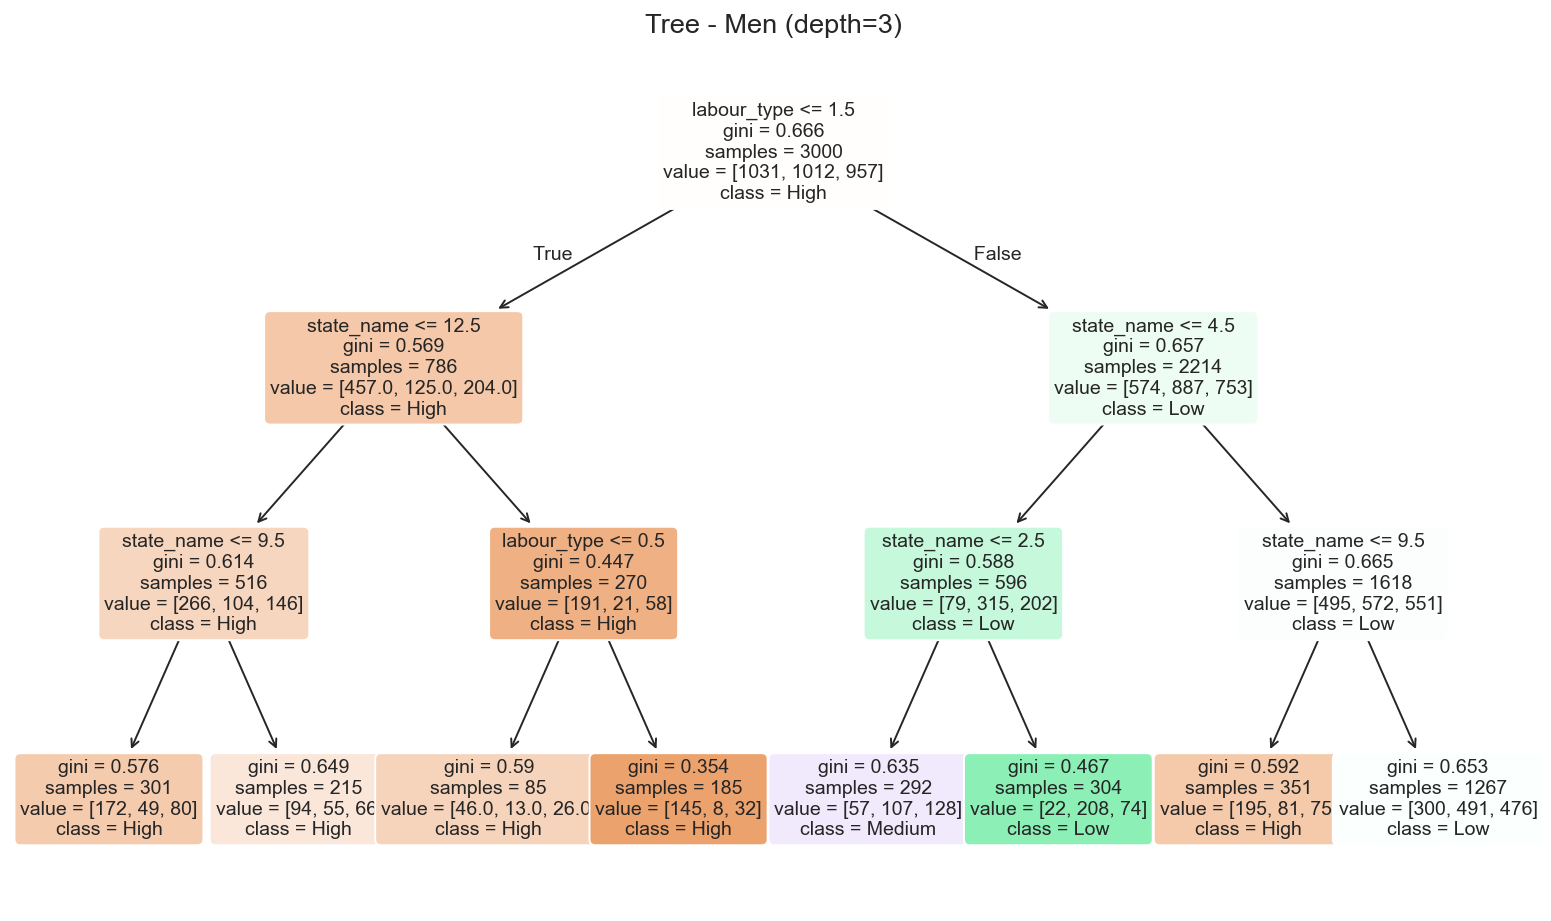


🌿 Showing tree for gender: Women


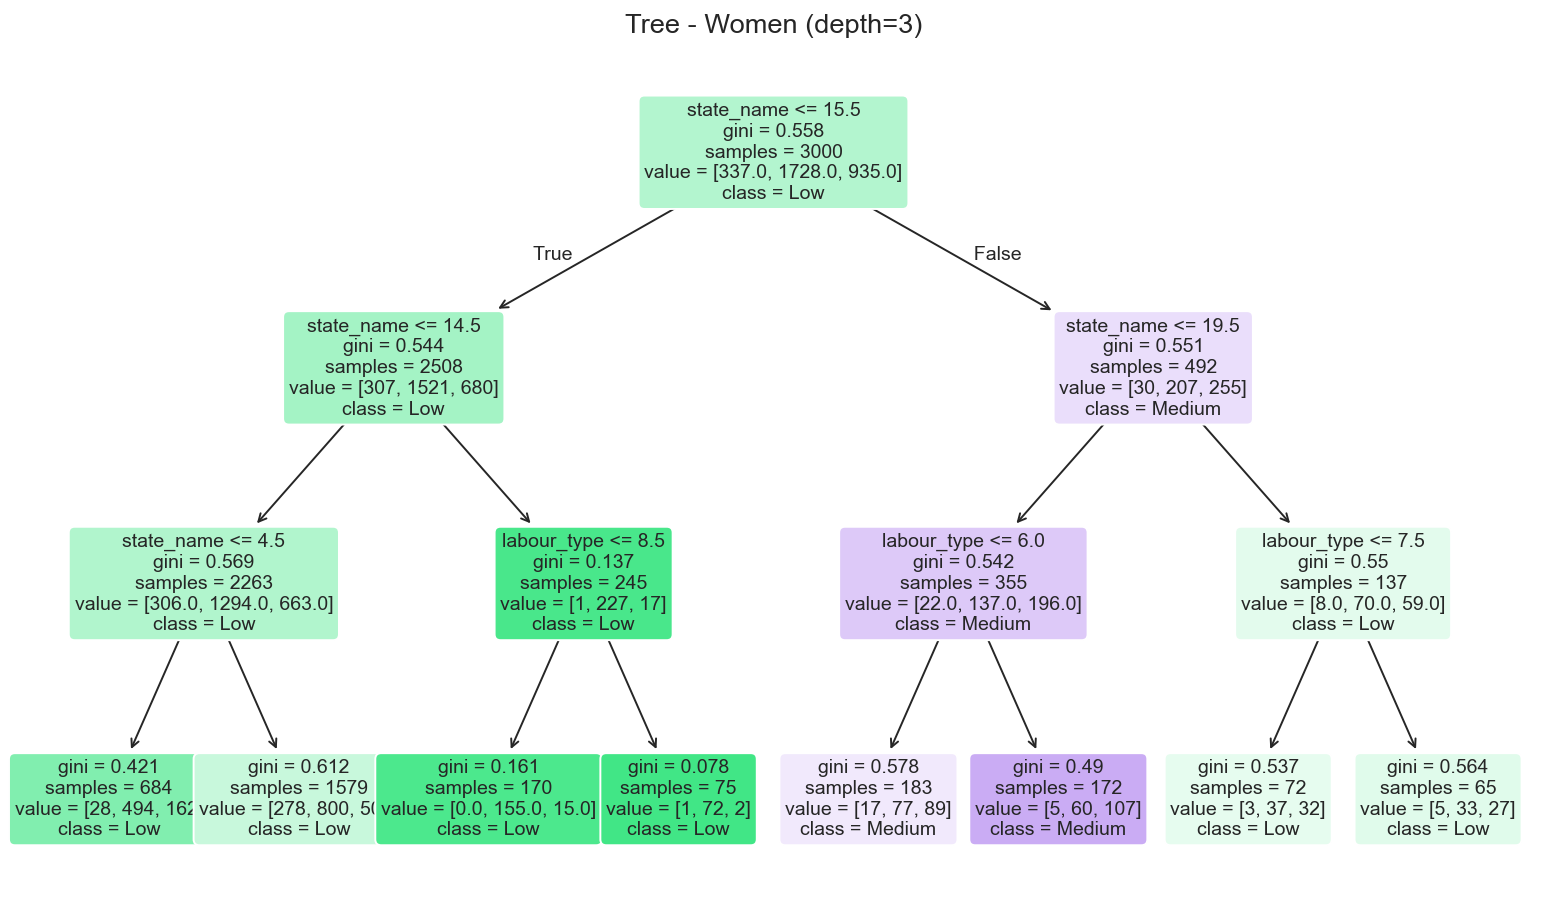


🏛 Showing tree for state: Odisha


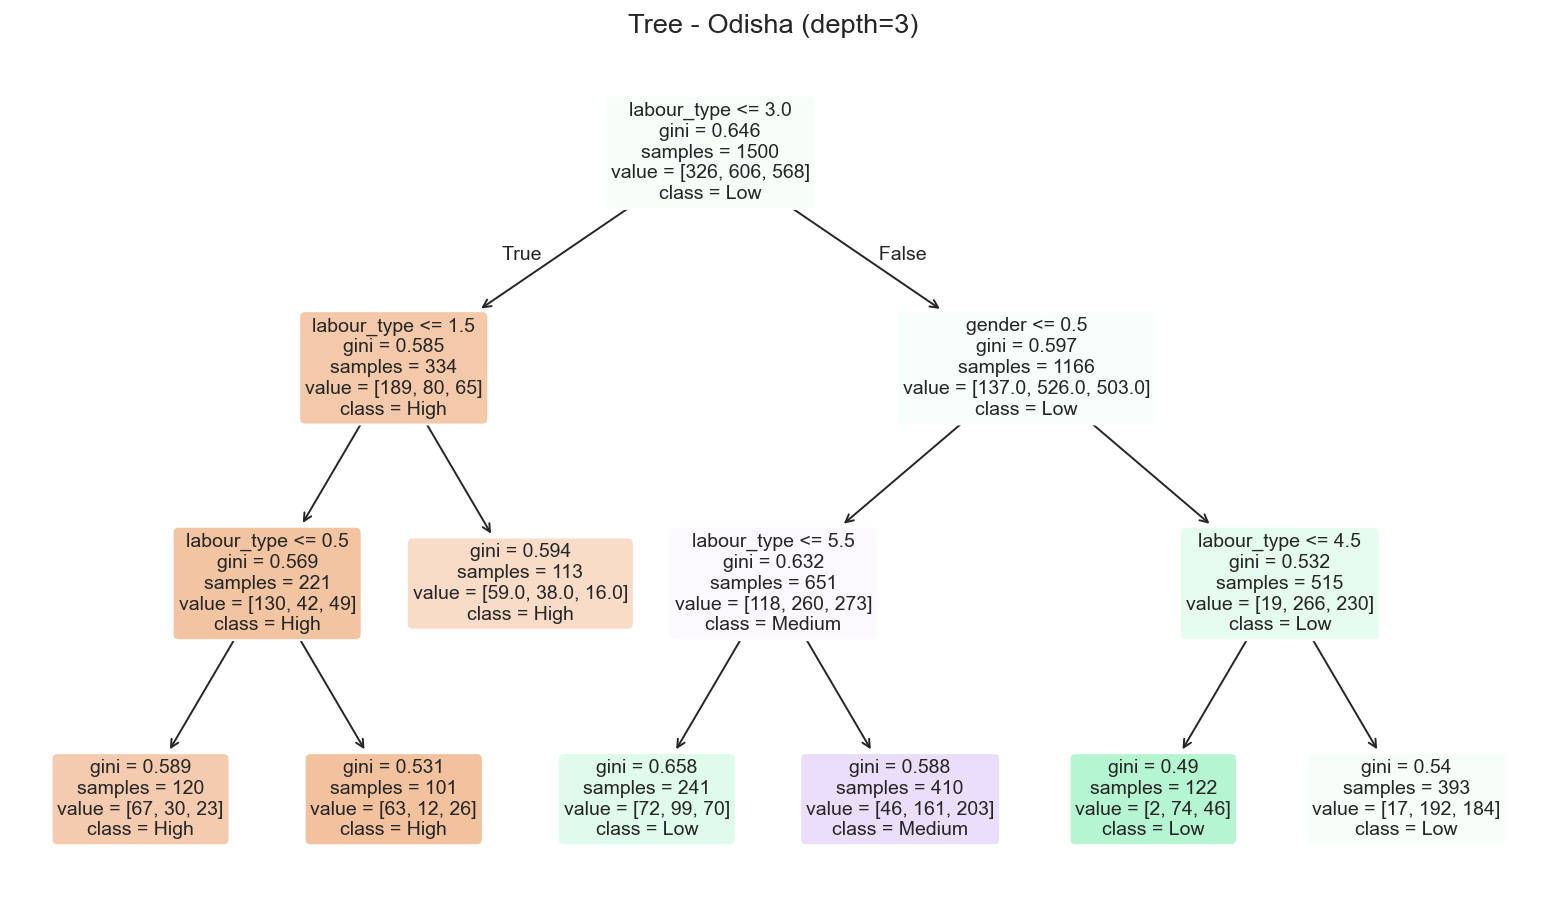


🏛 Showing tree for state: Madhya Pradesh


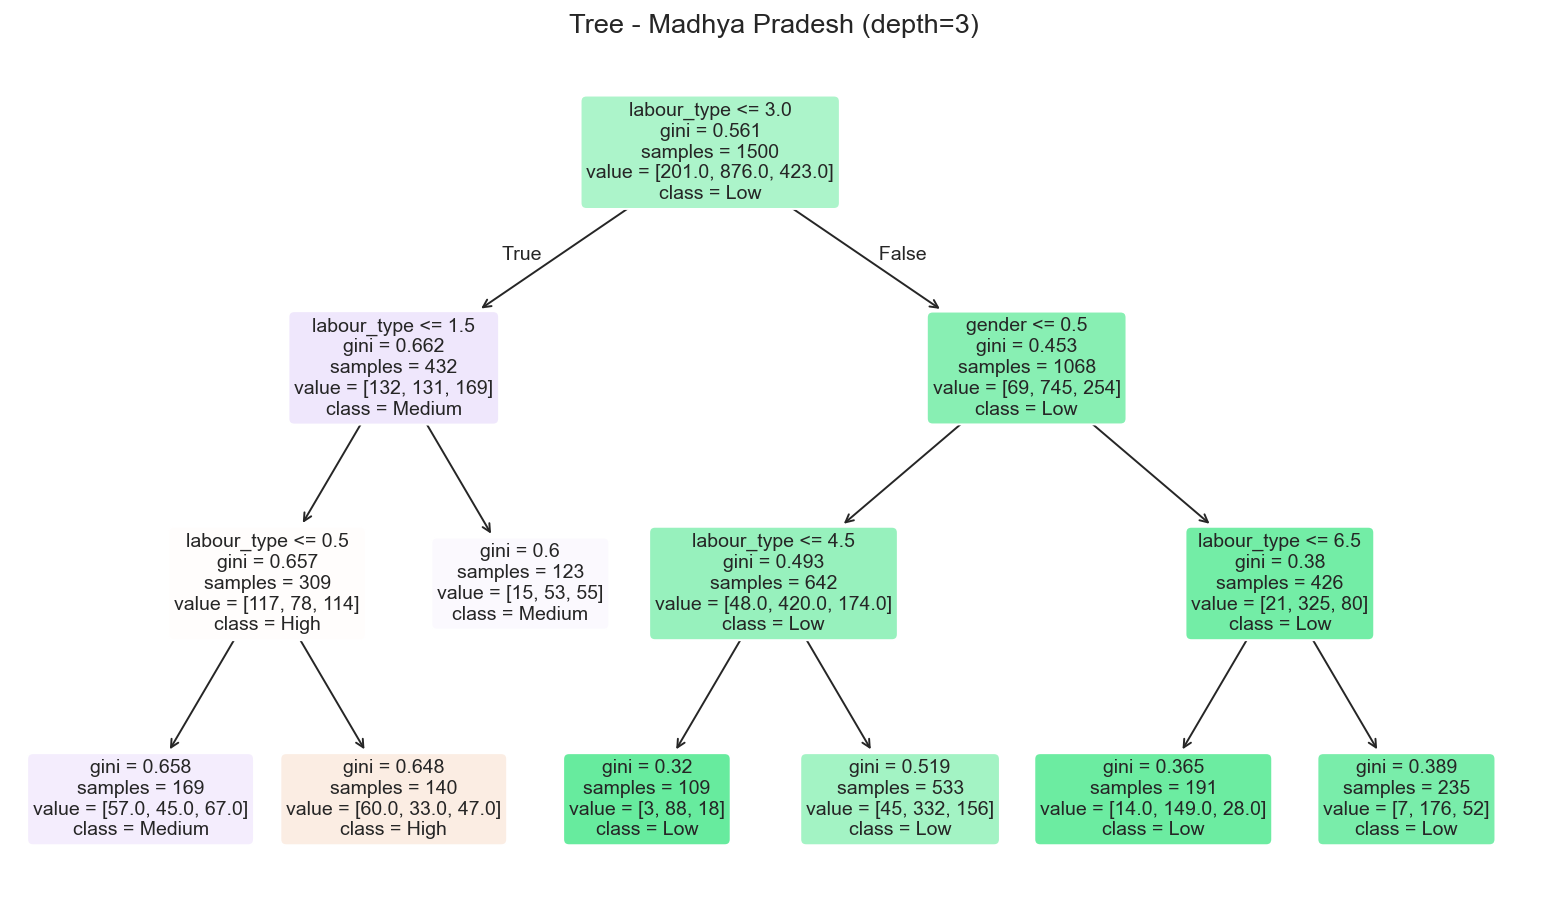


🏛 Showing tree for state: Gujarat


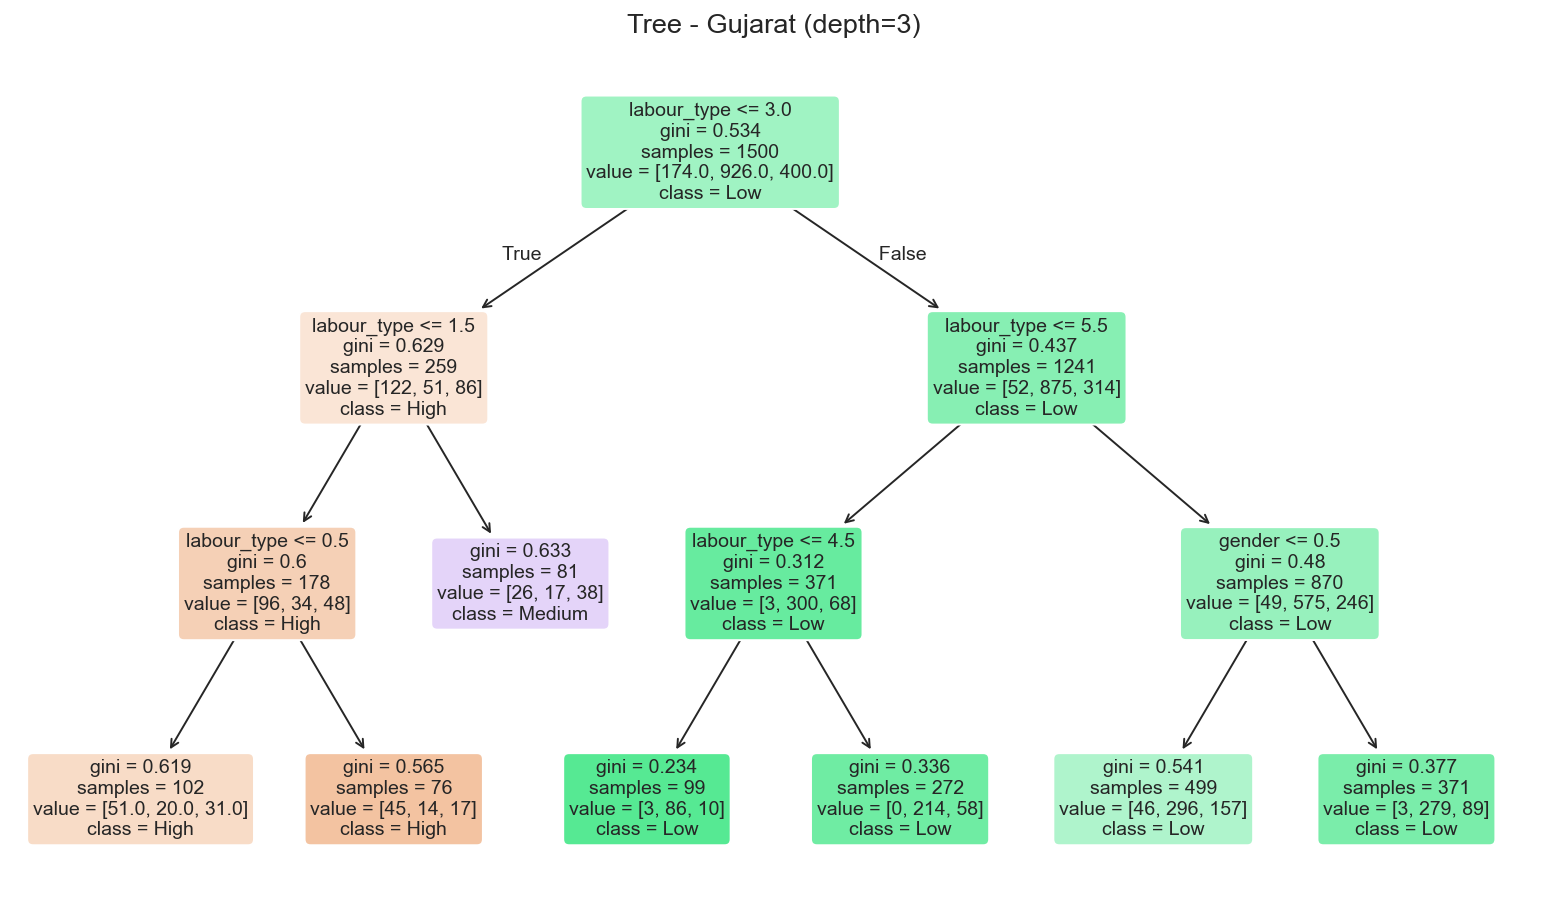


📊 Showing one-vs-rest tree for: High


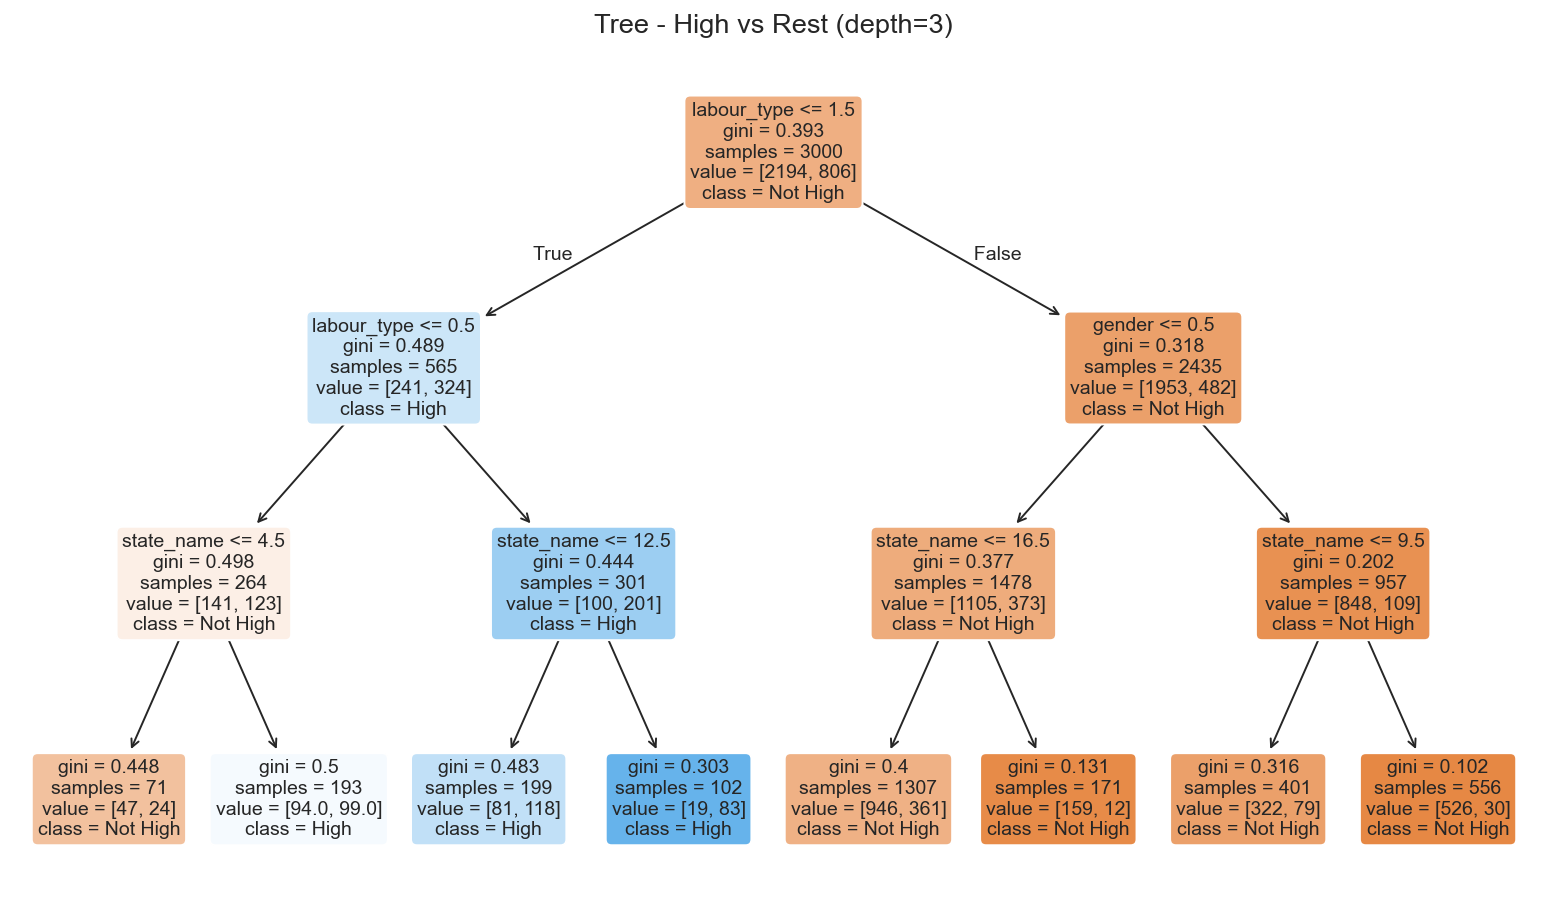


📊 Showing one-vs-rest tree for: Low


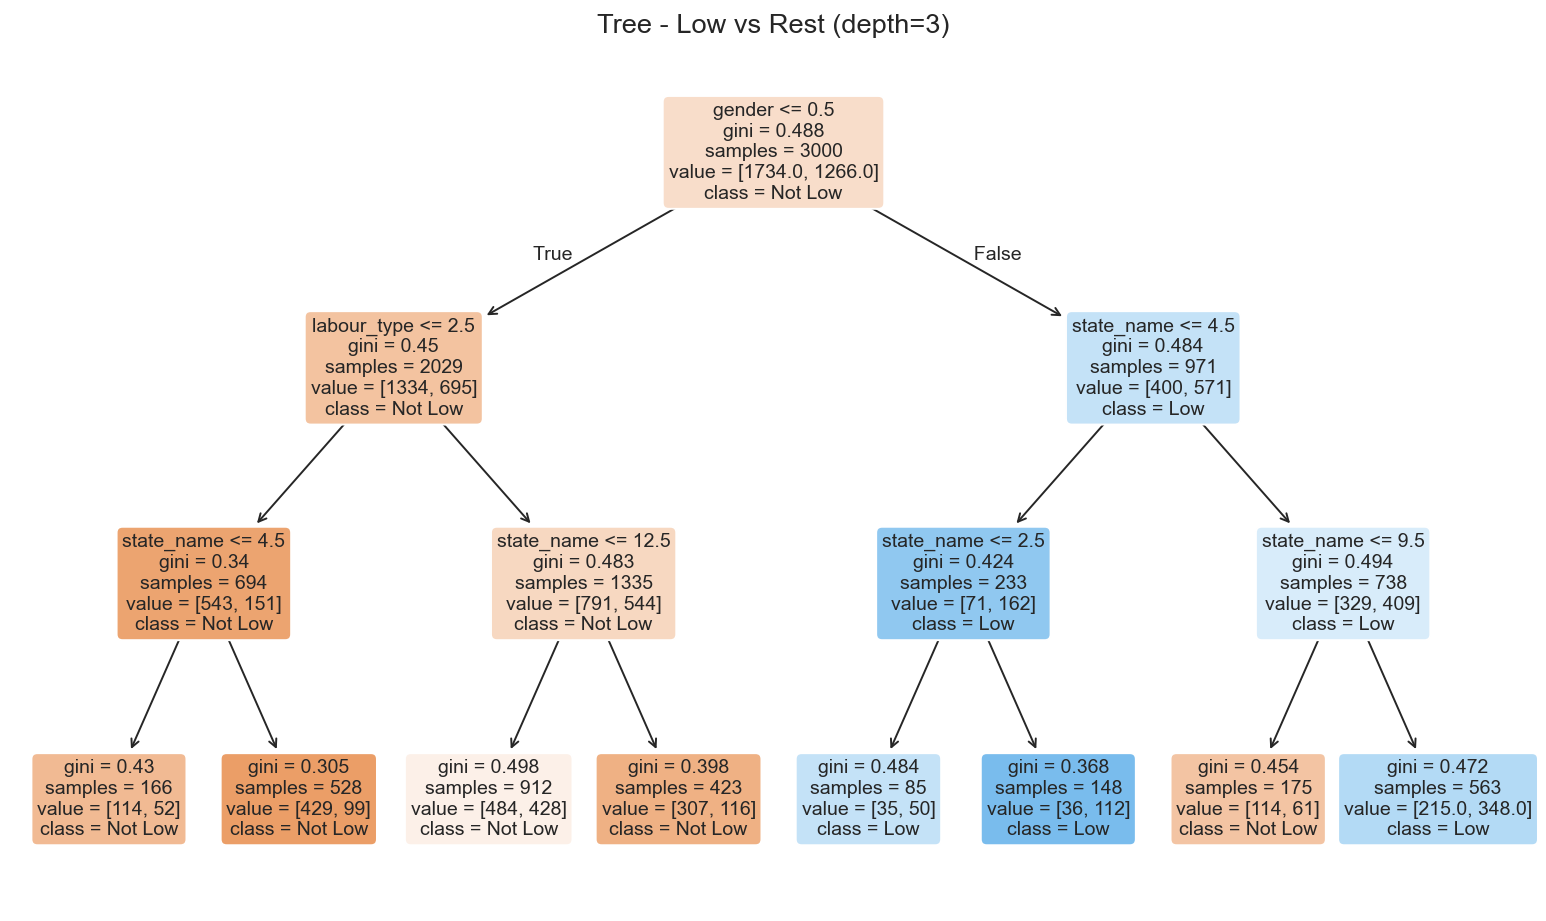


📊 Showing one-vs-rest tree for: Medium


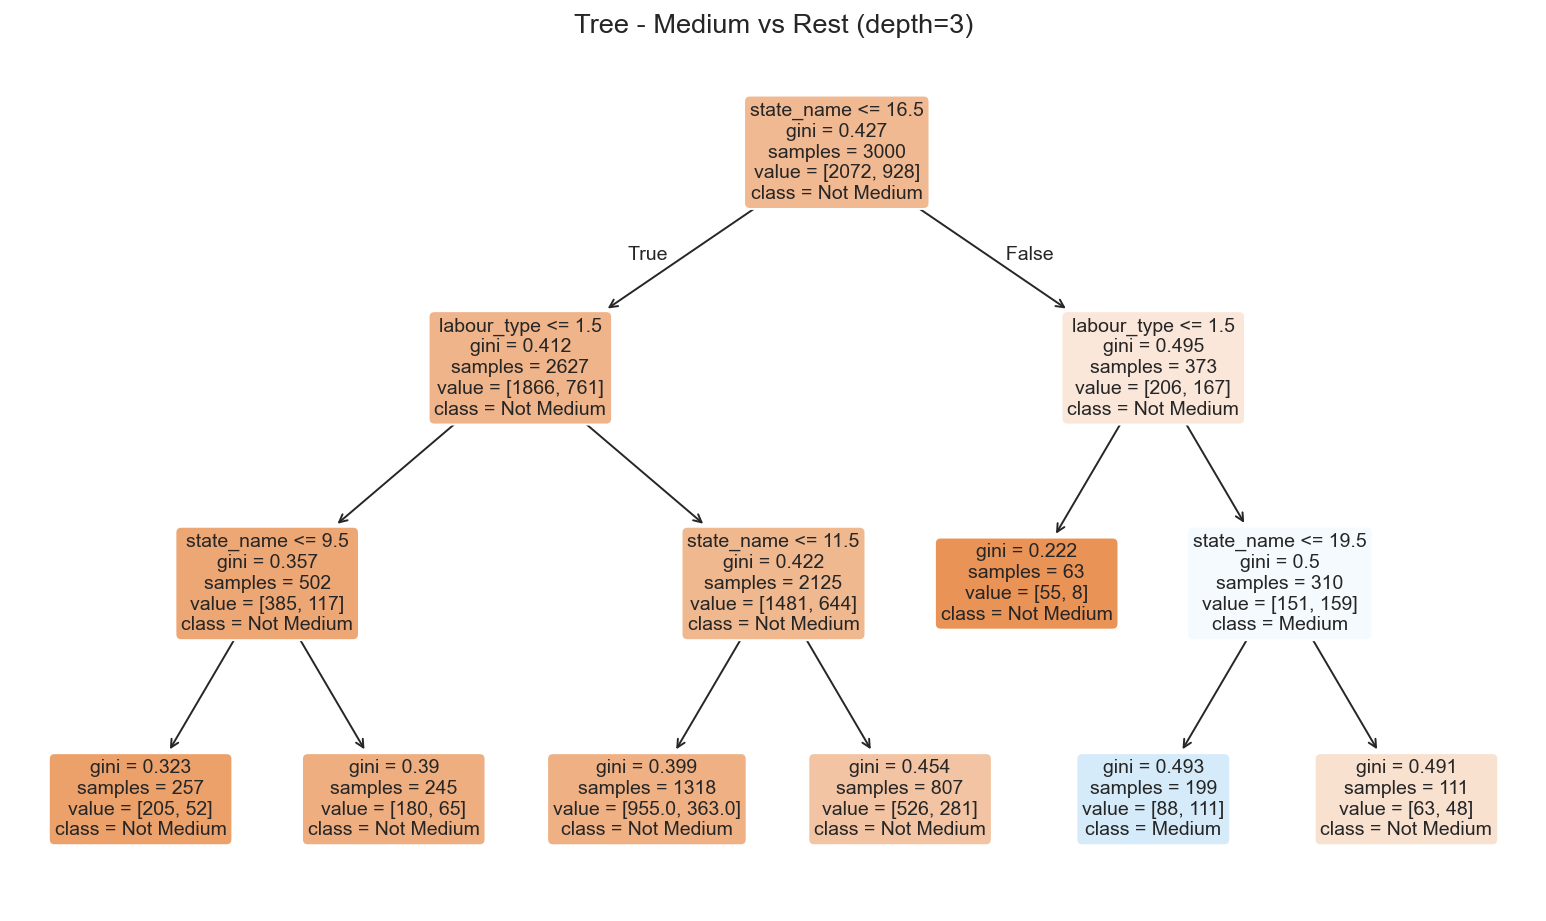

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# CONFIG
FILE = "cleaned_agri_wages.csv"   # update path if needed
FEATURES = ["gender", "labour_type", "state_name"]
TARGET_WAGE = "monthly_average_wage"
MAX_DEPTH = 3
SAMPLE_FOR_VIS = 3000  # sample size for clarity (None = use all)

# Load dataset
df = pd.read_csv(FILE)
df = df.dropna(subset=FEATURES + [TARGET_WAGE])
print("Rows after dropna:", len(df))

# Create wage category if not present
if "wage_cat" not in df.columns:
    low, high = np.percentile(df[TARGET_WAGE], [33.3, 66.6])
    def wc(x):
        if x <= low: return "Low"
        if x <= high: return "Medium"
        return "High"
    df["wage_cat"] = df[TARGET_WAGE].apply(wc)
    print(f"Created wage_cat with thresholds low={low:.2f}, high={high:.2f}")

# Encode features
encoders = {}
X_enc = pd.DataFrame(index=df.index)
for col in FEATURES:
    le = LabelEncoder()
    X_enc[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

y_le = LabelEncoder()
y_enc = y_le.fit_transform(df["wage_cat"])

# Function to train and directly show tree
def train_and_show_tree(X, y, name, features=FEATURES, class_names=None, sample=None, max_depth=MAX_DEPTH):
    if sample is not None and len(X) > sample:
        samp_idx = np.random.RandomState(42).choice(X.index, size=sample, replace=False)
        Xs = X.loc[samp_idx]
        ys = y[samp_idx]
    else:
        Xs = X
        ys = y

    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=50, random_state=42)
    clf.fit(Xs, ys)

    # Plot directly instead of saving
    plt.figure(figsize=(14, 8))
    plot_tree(clf, feature_names=features, class_names=class_names, filled=True, rounded=True, fontsize=10)
    plt.title(f"{name} (depth={max_depth})", fontsize=14)
    plt.show()

# Prepare encoded data
X_all = X_enc.copy()
y_all = pd.Series(y_enc, index=X_all.index)
class_names = list(y_le.classes_)

# 1️⃣ Overall tree
train_and_show_tree(X_all, y_all, "Overall Decision Tree", features=FEATURES, class_names=class_names, sample=SAMPLE_FOR_VIS)

# 2️⃣ Gender-specific trees
gender_encoder = encoders["gender"]
for gender_label in gender_encoder.classes_:
    code = np.where(gender_encoder.classes_ == gender_label)[0][0]
    idx = X_all[X_all["gender"] == code].index
    if len(idx) < 100:
        continue
    print(f"\n🌿 Showing tree for gender: {gender_label}")
    X_slice = X_all.loc[idx]
    y_slice = y_all.loc[idx]
    train_and_show_tree(X_slice, y_slice, f"Tree - {gender_label}", features=FEATURES, class_names=class_names, sample=SAMPLE_FOR_VIS)

# 3️⃣ Top N states trees (by count)
state_encoder = encoders["state_name"]
state_counts = df["state_name"].value_counts().head(3)  # fewer for readability
for state in state_counts.index:
    code = state_encoder.transform([state])[0]
    idx = X_all[X_all["state_name"] == code].index
    if len(idx) < 200:
        continue
    print(f"\n🏛 Showing tree for state: {state}")
    X_slice = X_all.loc[idx]
    y_slice = y_all.loc[idx]
    train_and_show_tree(X_slice, y_slice, f"Tree - {state}", features=FEATURES, class_names=class_names, sample=1500)

# 4️⃣ One-vs-rest trees for each wage class
for class_label in class_names:
    binary_y = (df["wage_cat"] == class_label).astype(int)
    print(f"\n📊 Showing one-vs-rest tree for: {class_label}")
    train_and_show_tree(X_all, binary_y, f"Tree - {class_label} vs Rest", features=FEATURES, class_names=[f"Not {class_label}", class_label], sample=SAMPLE_FOR_VIS)


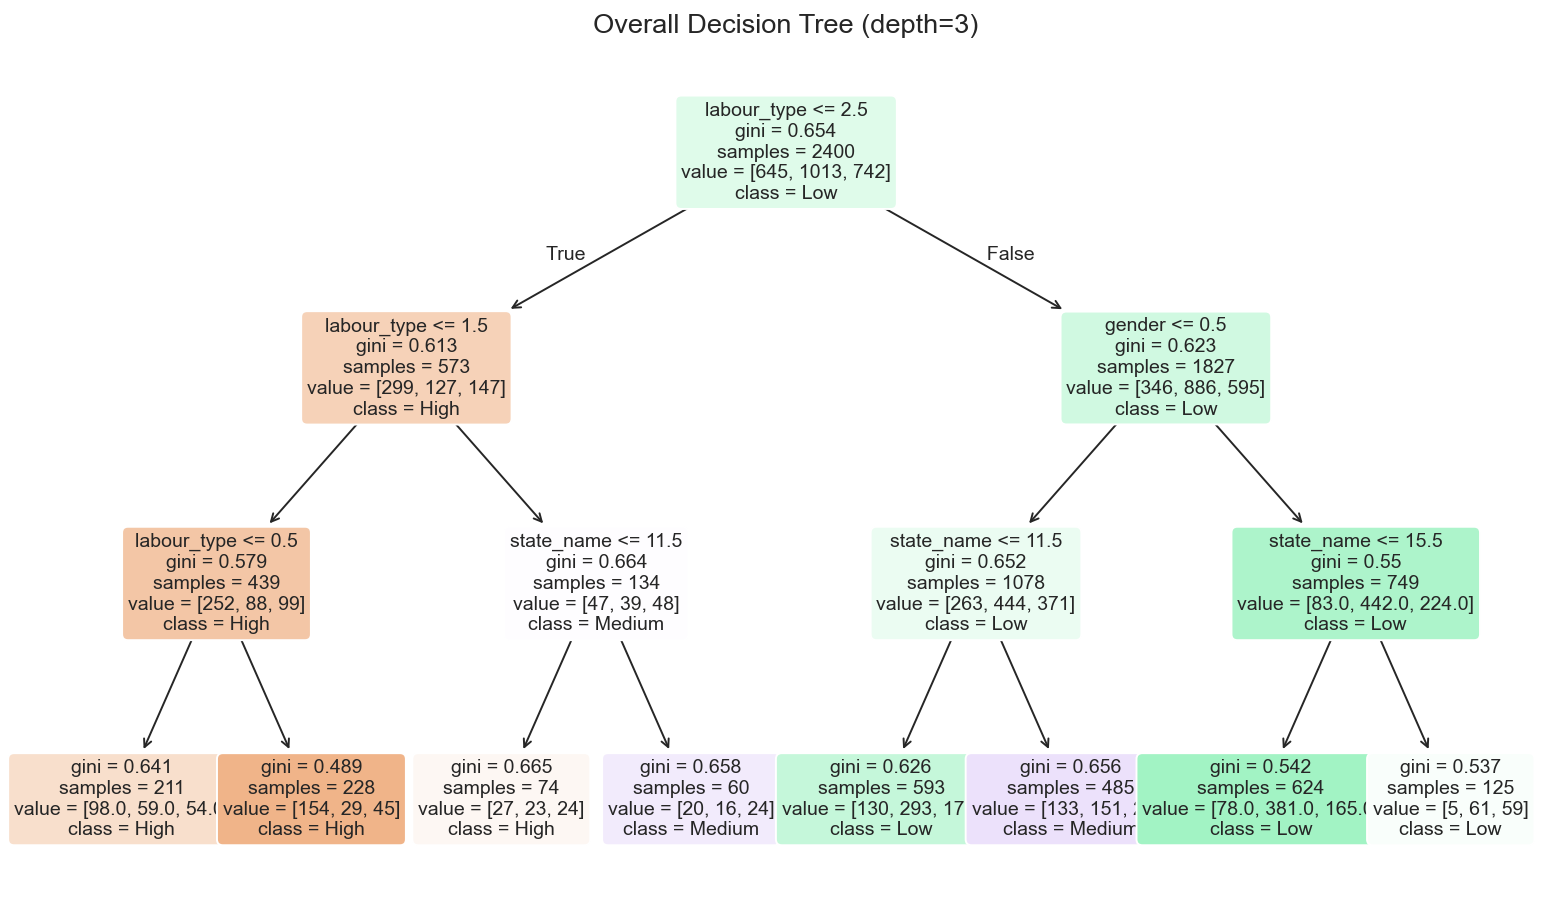


Overall Decision Tree — Test Accuracy: 51.50%

Classification Report:
              precision    recall  f1-score   support

        High       0.54      0.45      0.49       161
         Low       0.54      0.72      0.62       253
      Medium       0.42      0.28      0.34       186

    accuracy                           0.52       600
   macro avg       0.50      0.49      0.48       600
weighted avg       0.50      0.52      0.50       600



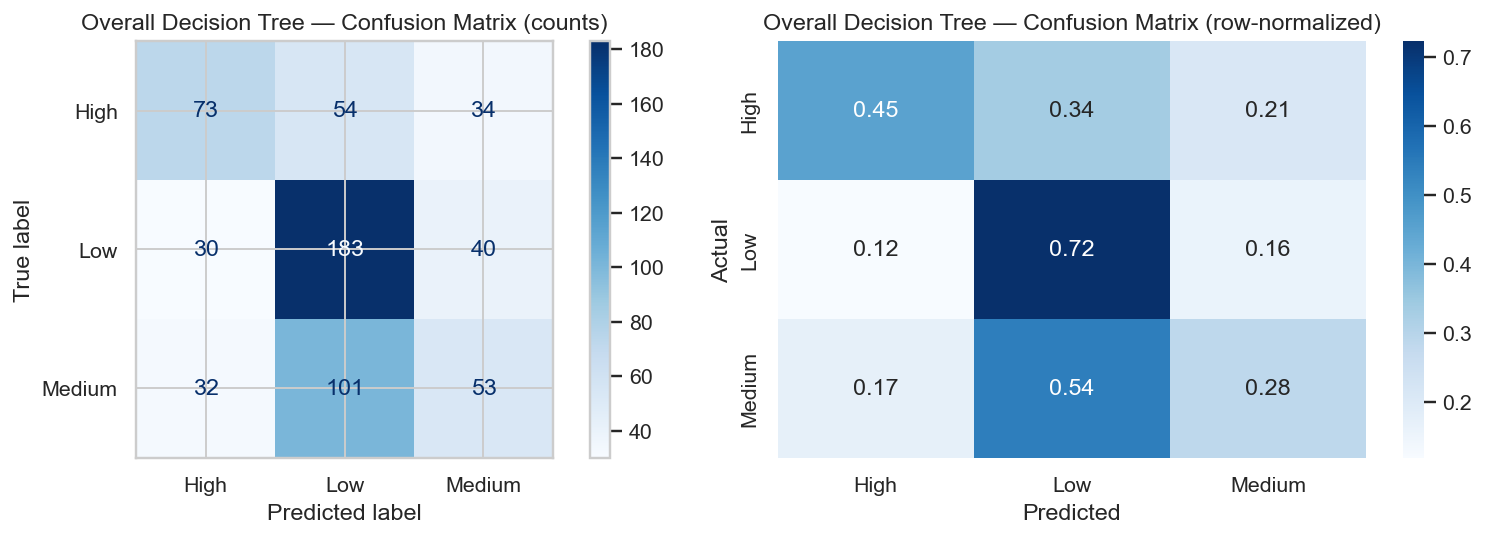

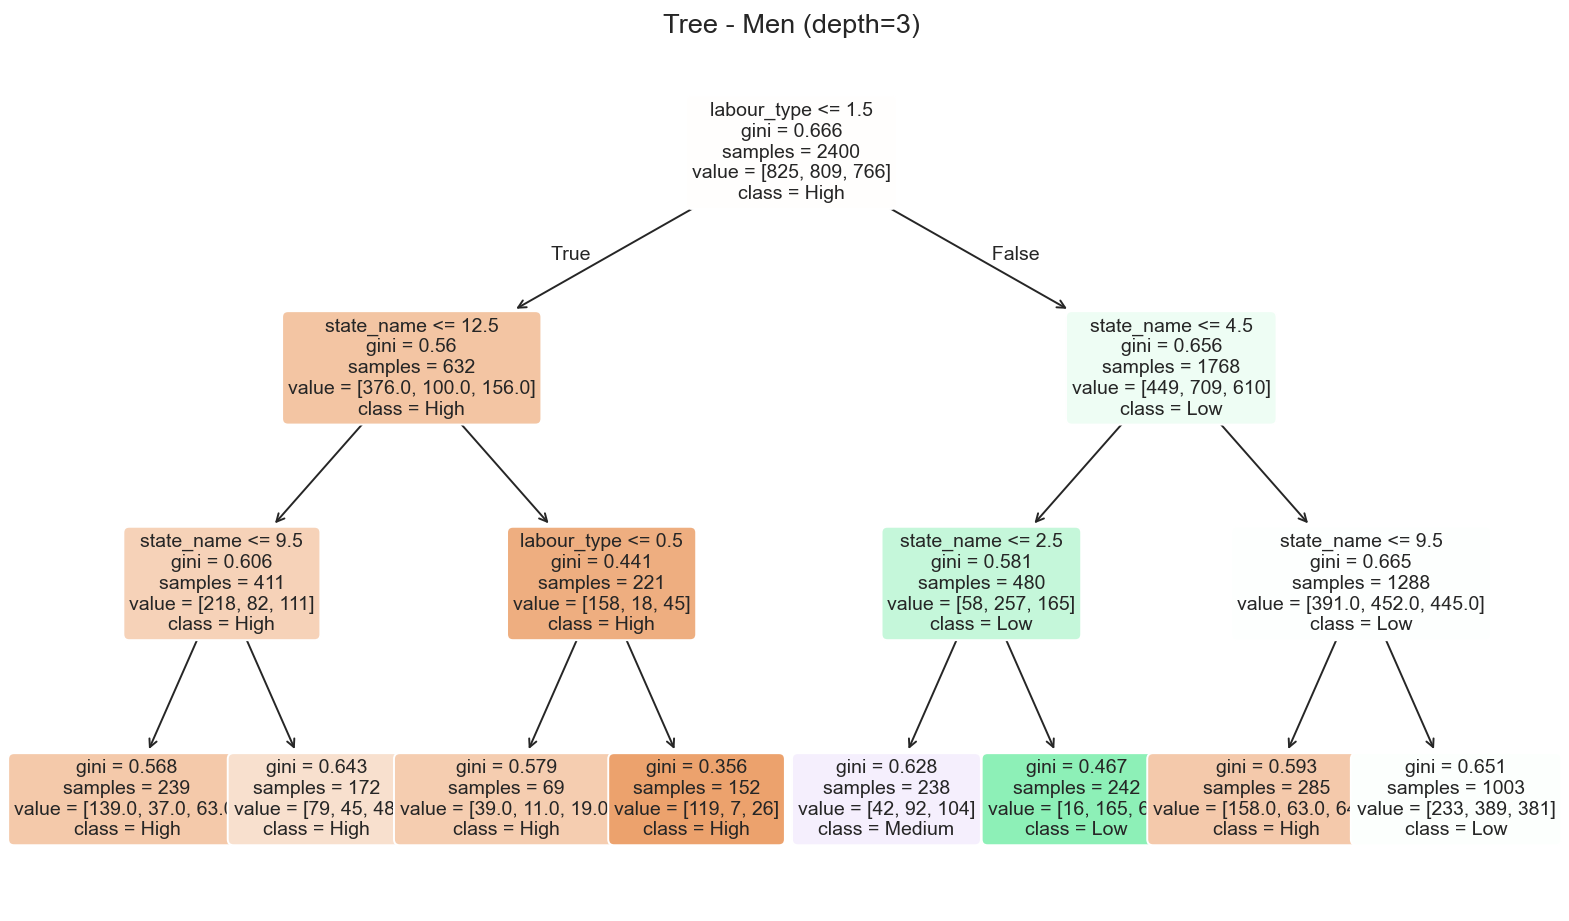


Tree - Men — Test Accuracy: 47.83%

Classification Report:
              precision    recall  f1-score   support

        High       0.54      0.57      0.55       206
         Low       0.44      0.71      0.55       203
      Medium       0.44      0.13      0.20       191

    accuracy                           0.48       600
   macro avg       0.48      0.47      0.43       600
weighted avg       0.48      0.48      0.44       600



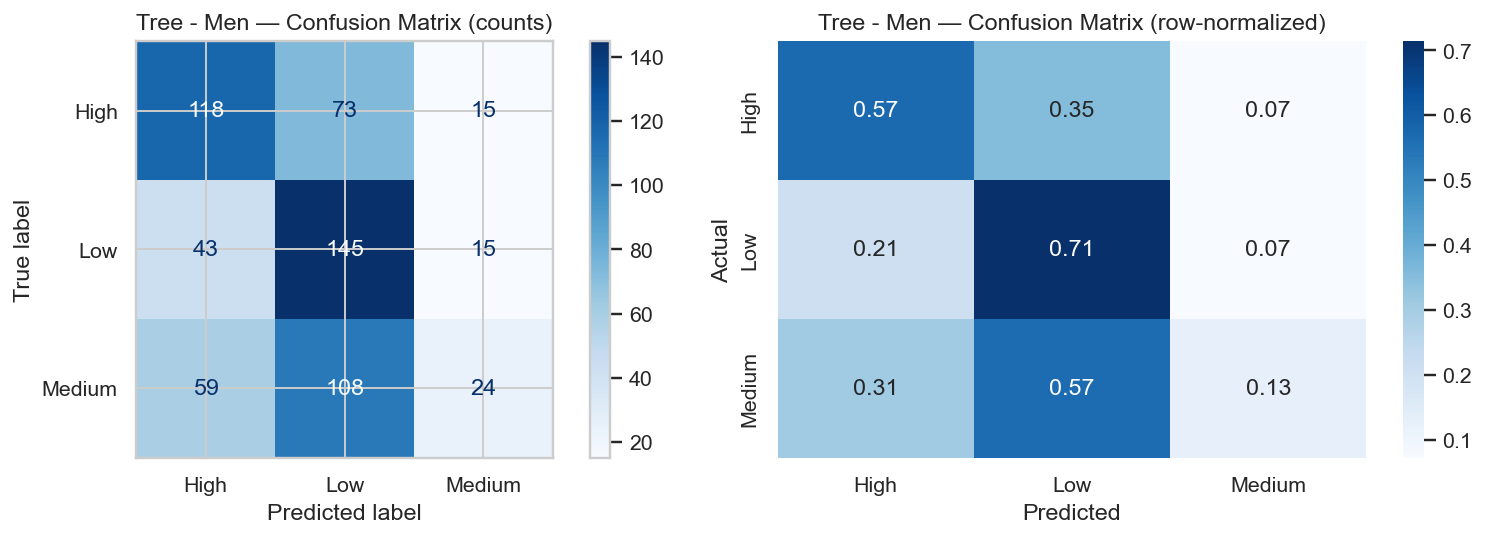

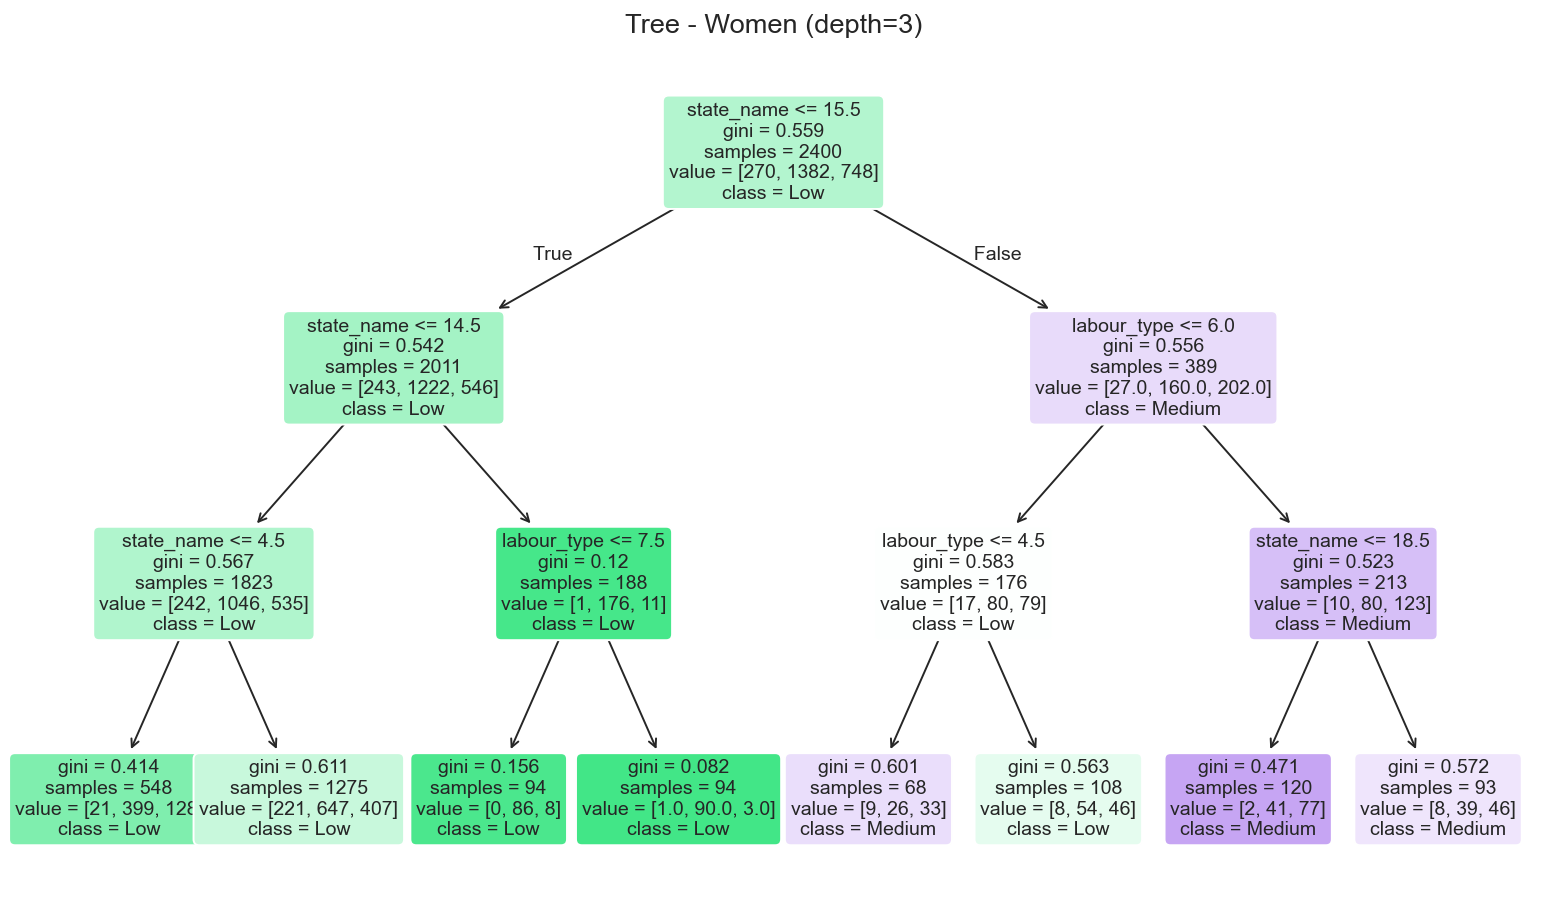


Tree - Women — Test Accuracy: 57.17%

Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        67
         Low       0.58      0.90      0.71       346
      Medium       0.47      0.16      0.24       187

    accuracy                           0.57       600
   macro avg       0.35      0.36      0.32       600
weighted avg       0.48      0.57      0.48       600



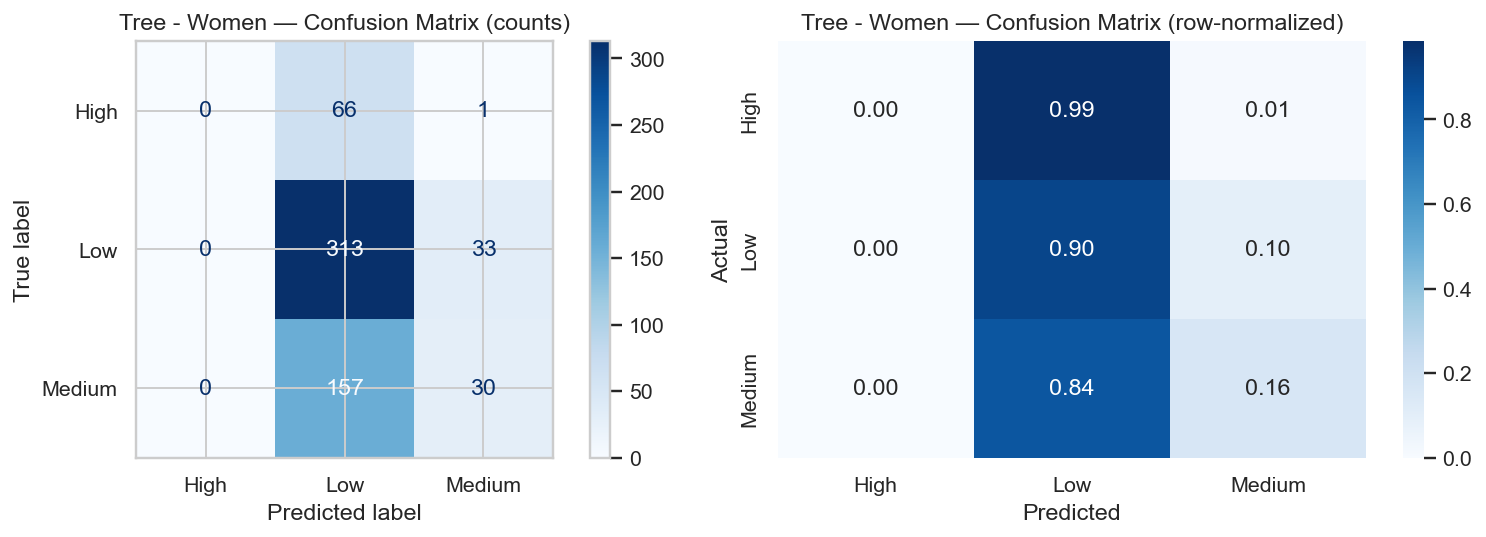

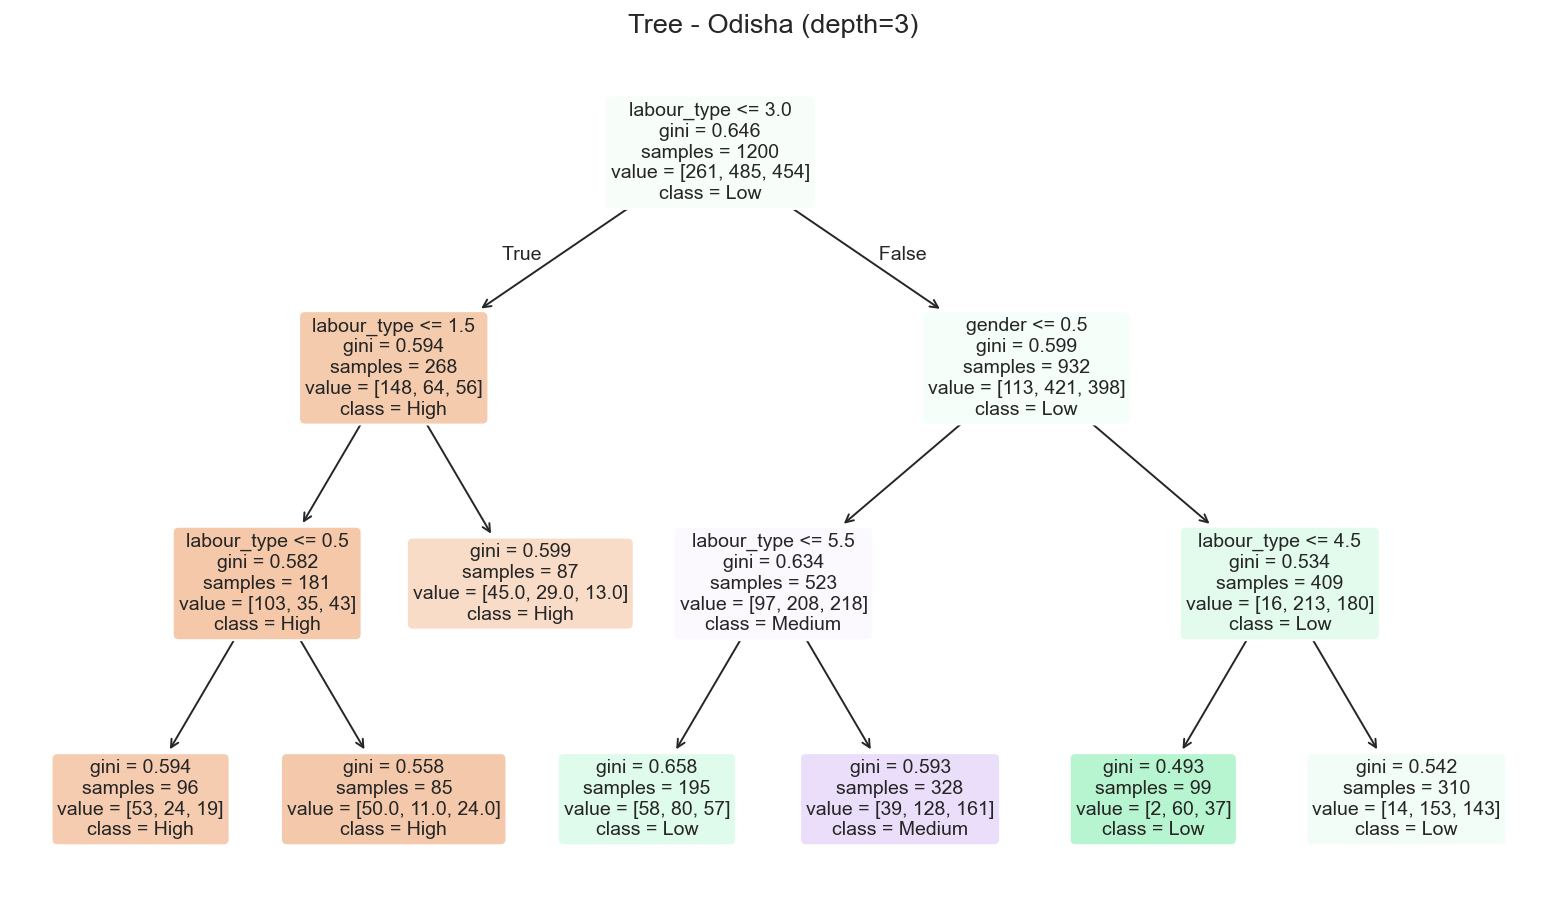


Tree - Odisha — Test Accuracy: 51.67%

Classification Report:
              precision    recall  f1-score   support

        High       0.62      0.63      0.63        65
         Low       0.47      0.60      0.53       121
      Medium       0.51      0.37      0.43       114

    accuracy                           0.52       300
   macro avg       0.54      0.53      0.53       300
weighted avg       0.52      0.52      0.51       300



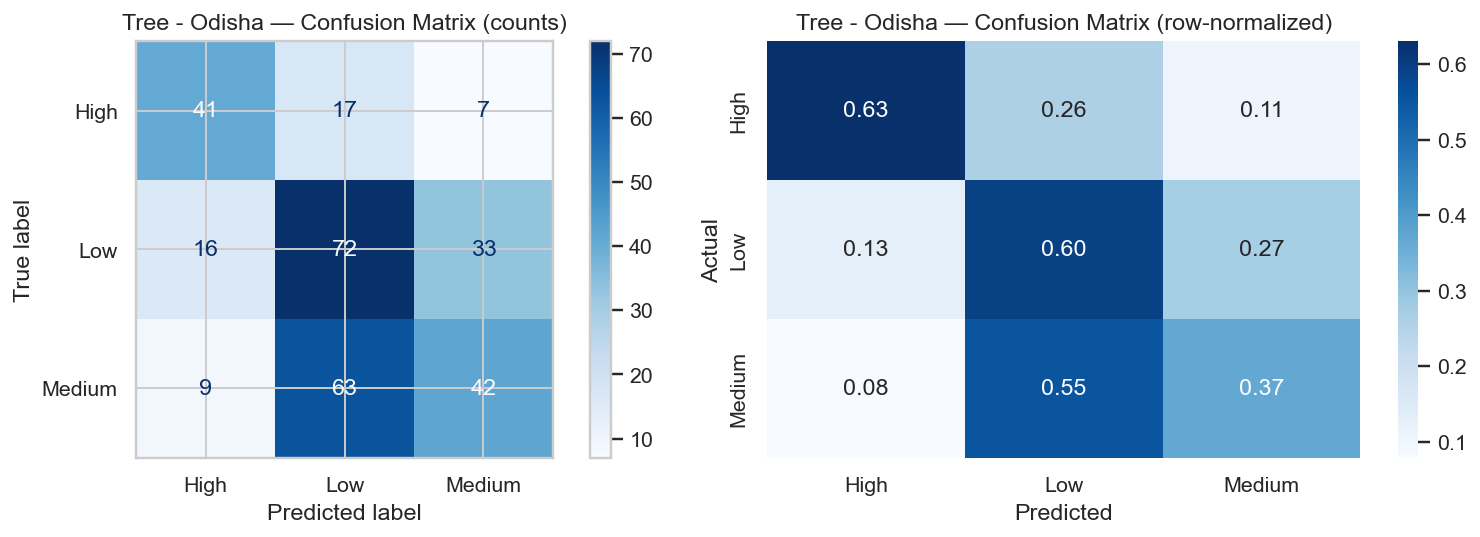

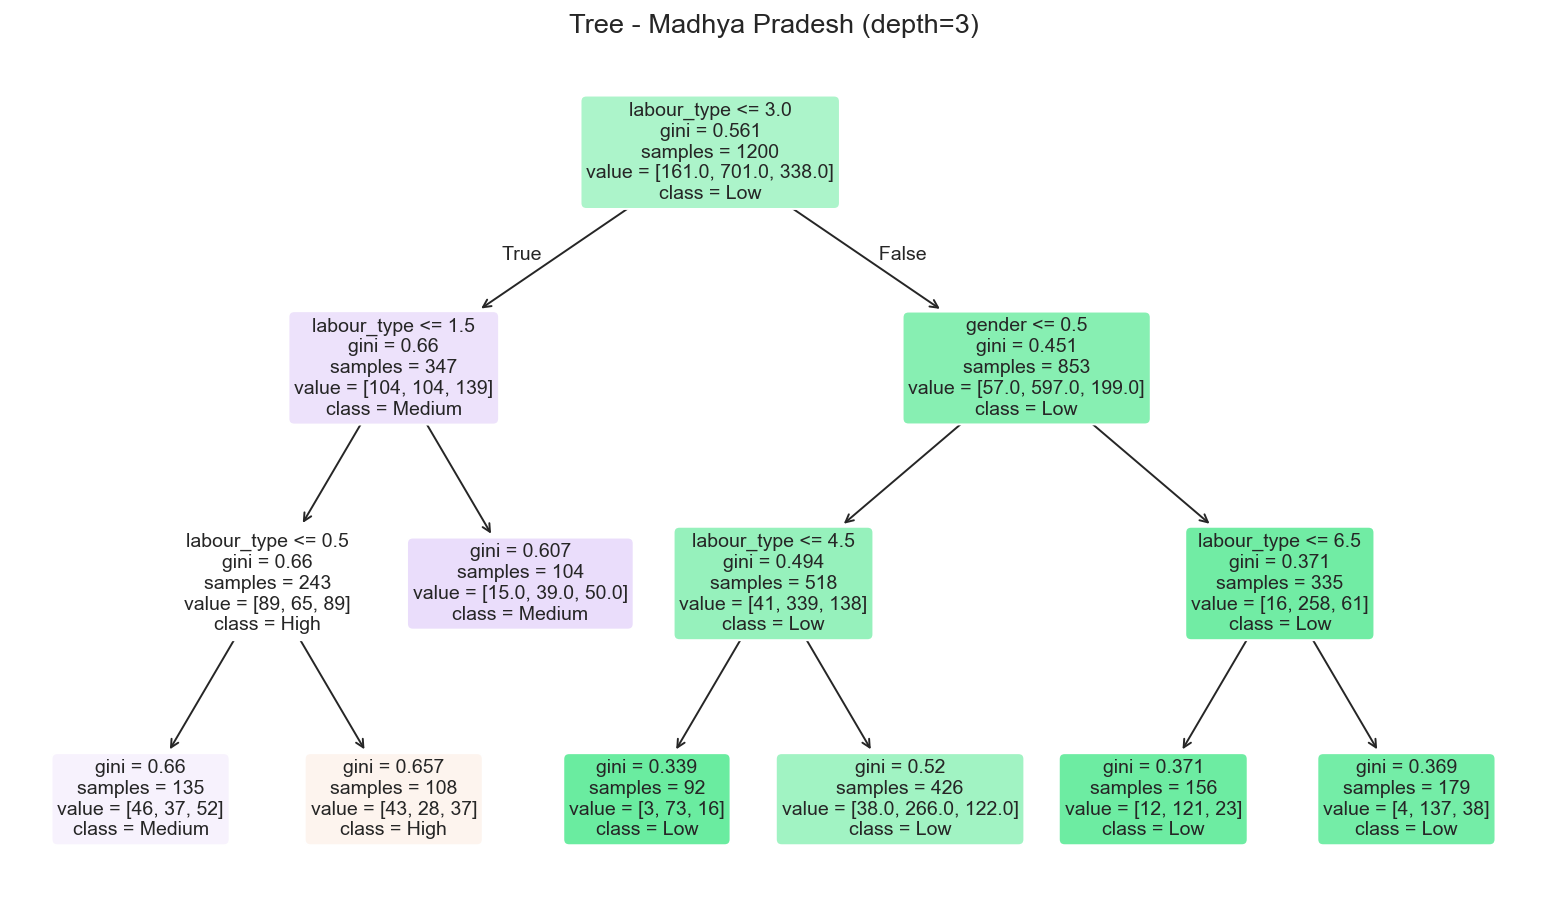


Tree - Madhya Pradesh — Test Accuracy: 61.67%

Classification Report:
              precision    recall  f1-score   support

        High       0.53      0.42      0.47        40
         Low       0.69      0.85      0.76       175
      Medium       0.38      0.24      0.29        85

    accuracy                           0.62       300
   macro avg       0.53      0.50      0.51       300
weighted avg       0.58      0.62      0.59       300



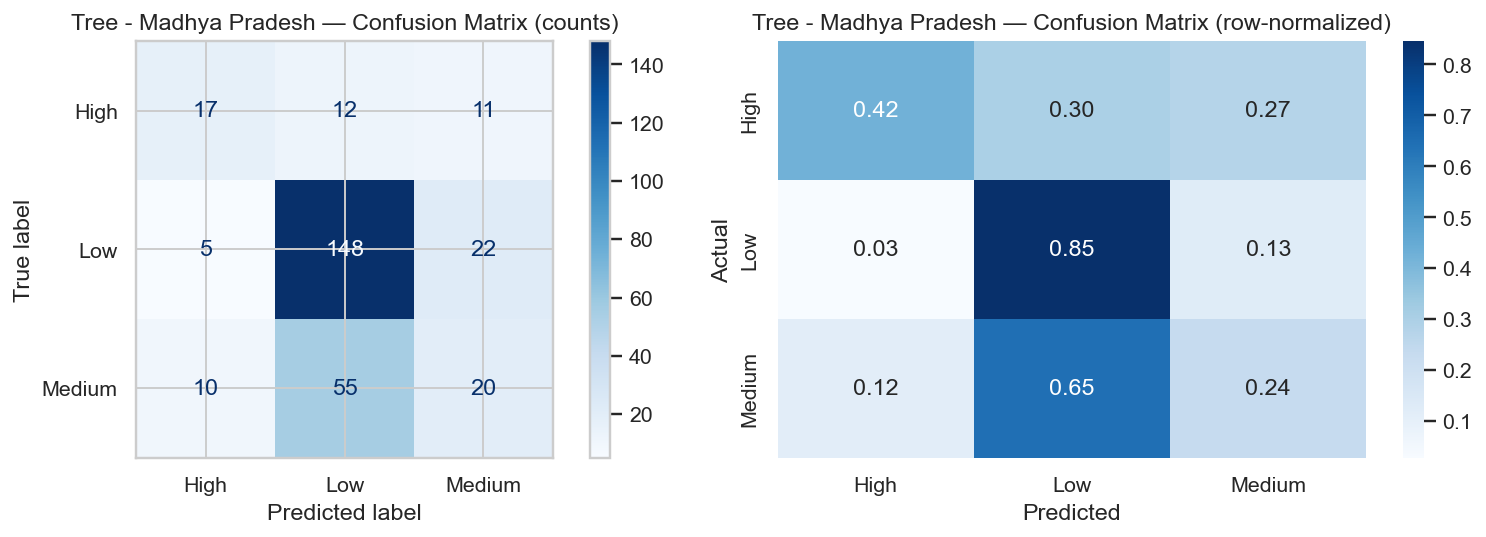

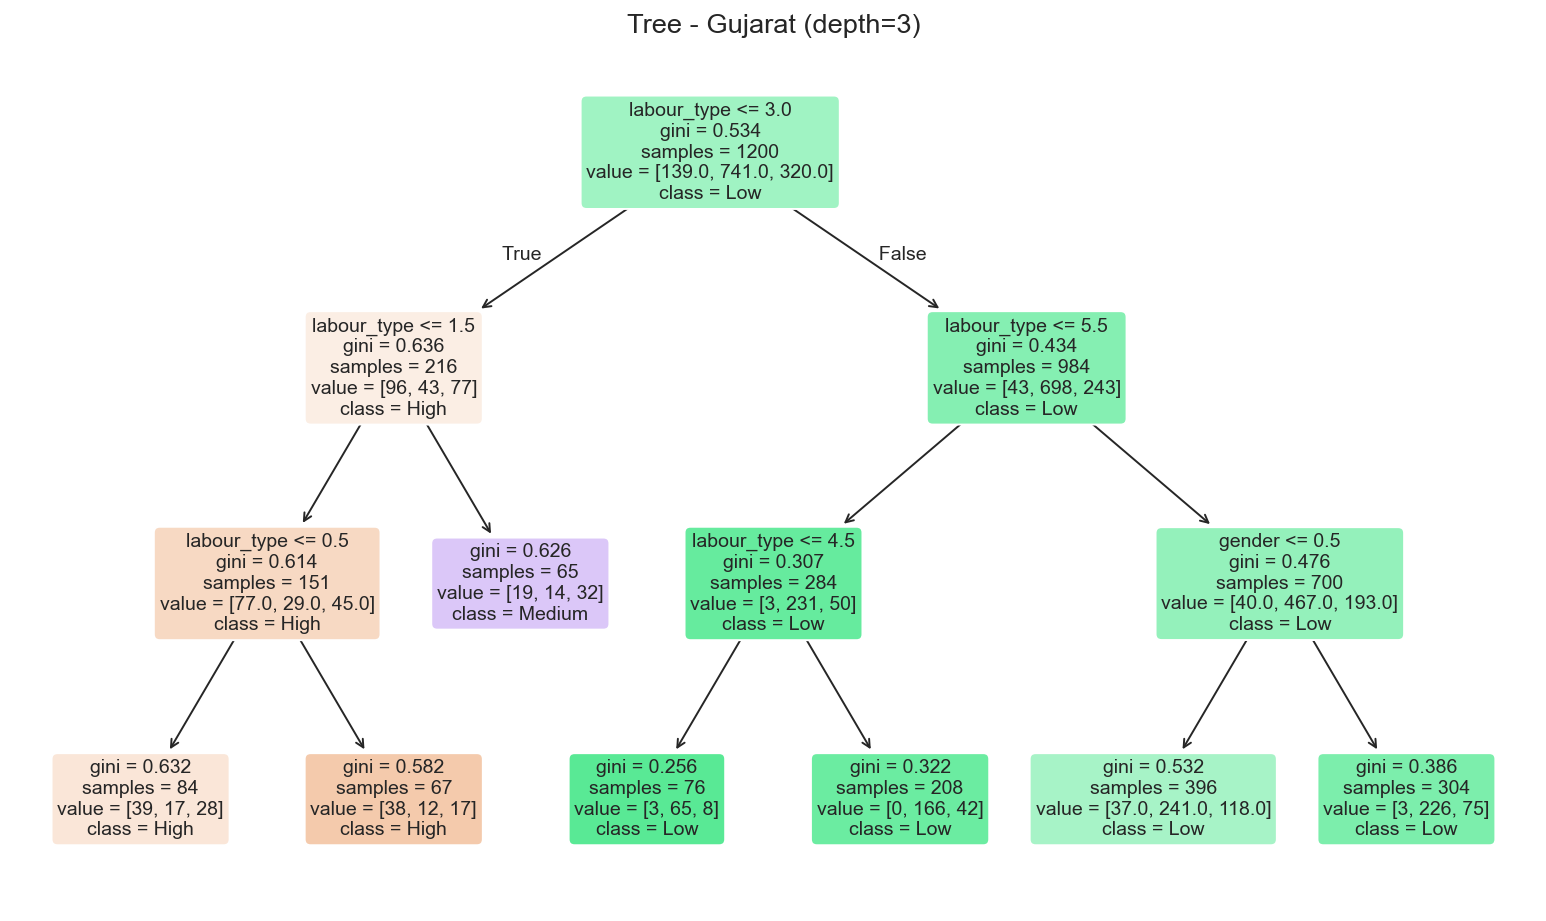


Tree - Gujarat — Test Accuracy: 67.33%

Classification Report:
              precision    recall  f1-score   support

        High       0.70      0.54      0.61        35
         Low       0.69      0.96      0.80       185
      Medium       0.38      0.07      0.12        80

    accuracy                           0.67       300
   macro avg       0.59      0.52      0.51       300
weighted avg       0.61      0.67      0.60       300



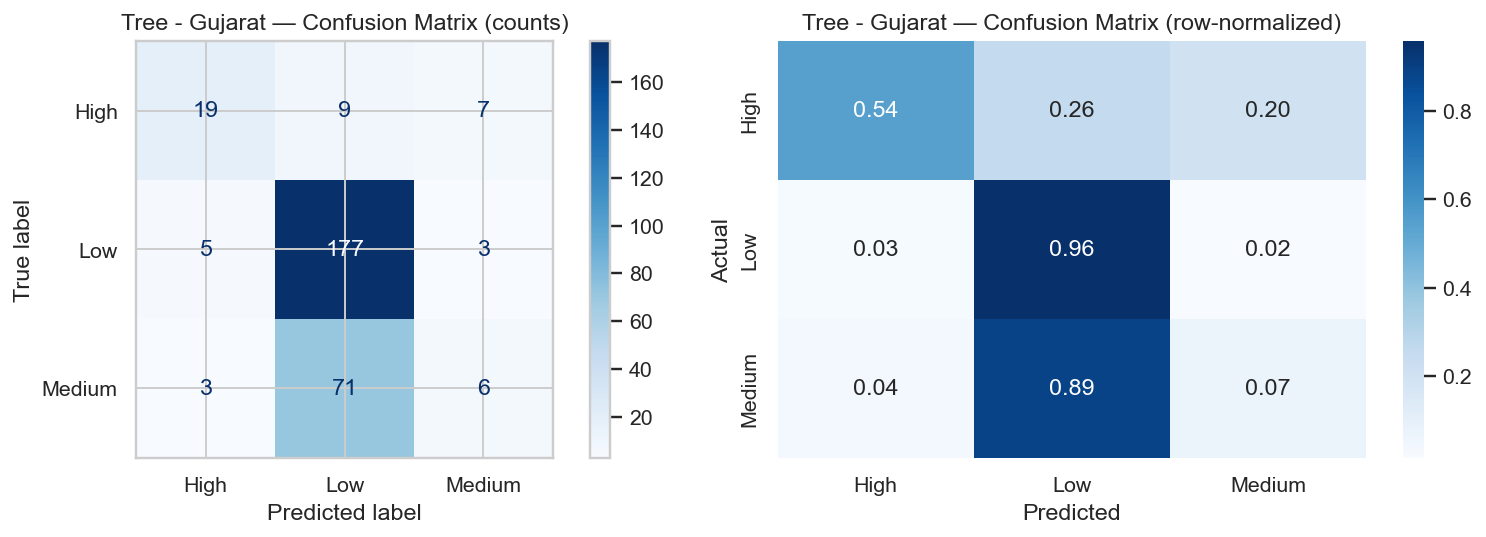

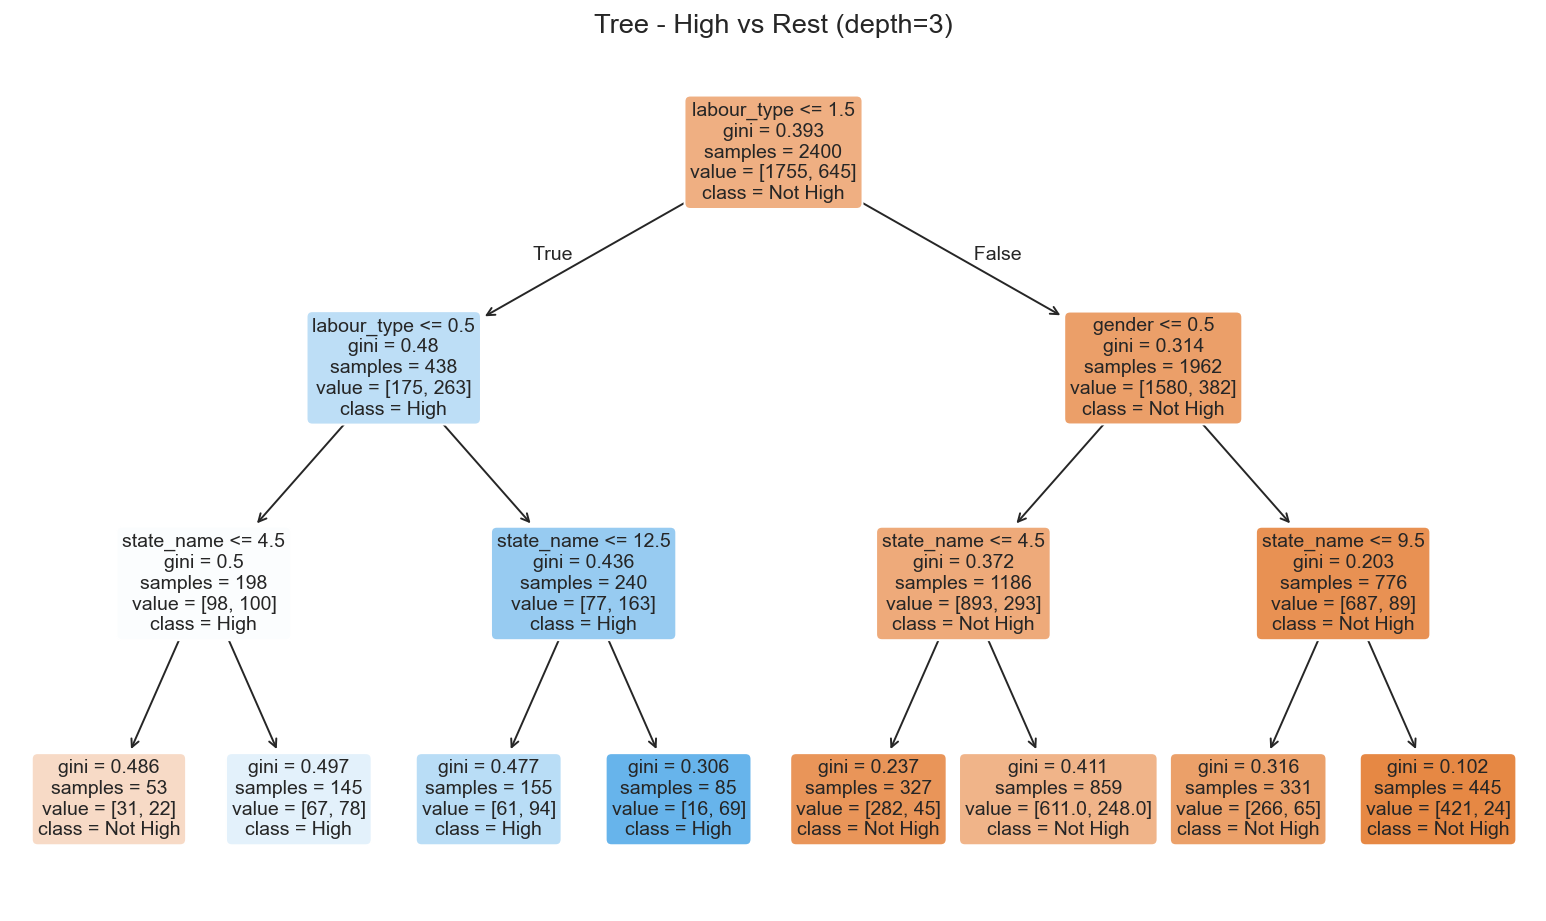


Tree - High vs Rest — Test Accuracy: 74.67%

Classification Report:
              precision    recall  f1-score   support

    Not High       0.79      0.89      0.84       439
        High       0.54      0.37      0.44       161

    accuracy                           0.75       600
   macro avg       0.67      0.63      0.64       600
weighted avg       0.72      0.75      0.73       600



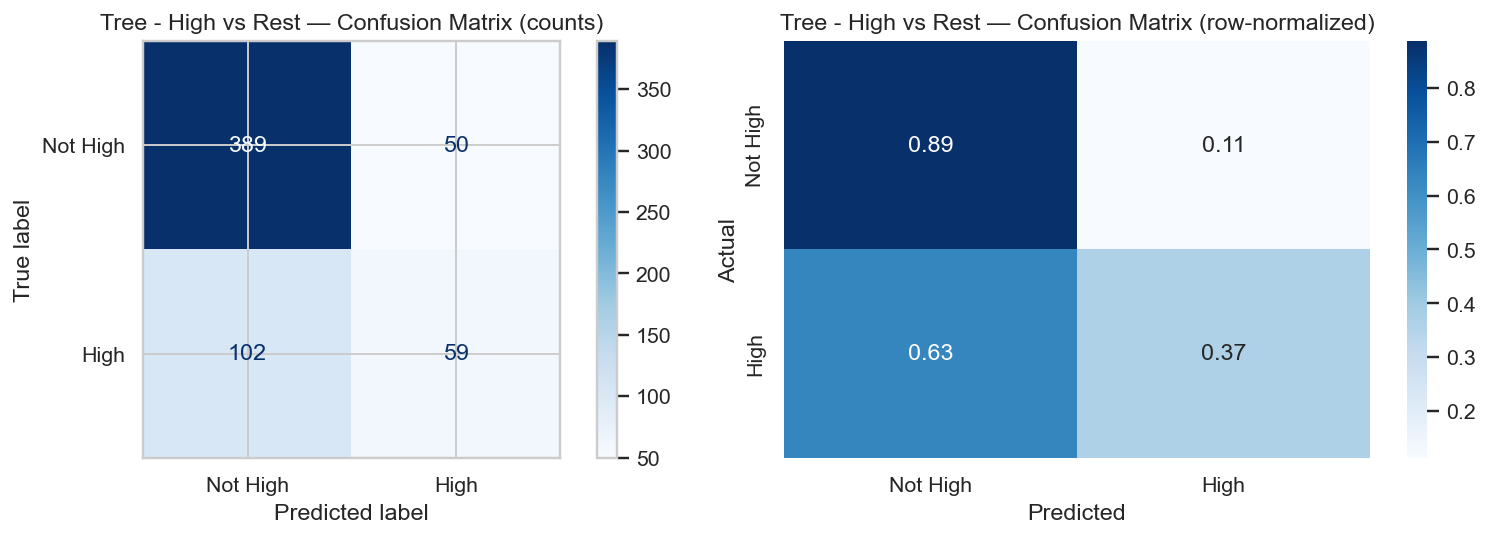

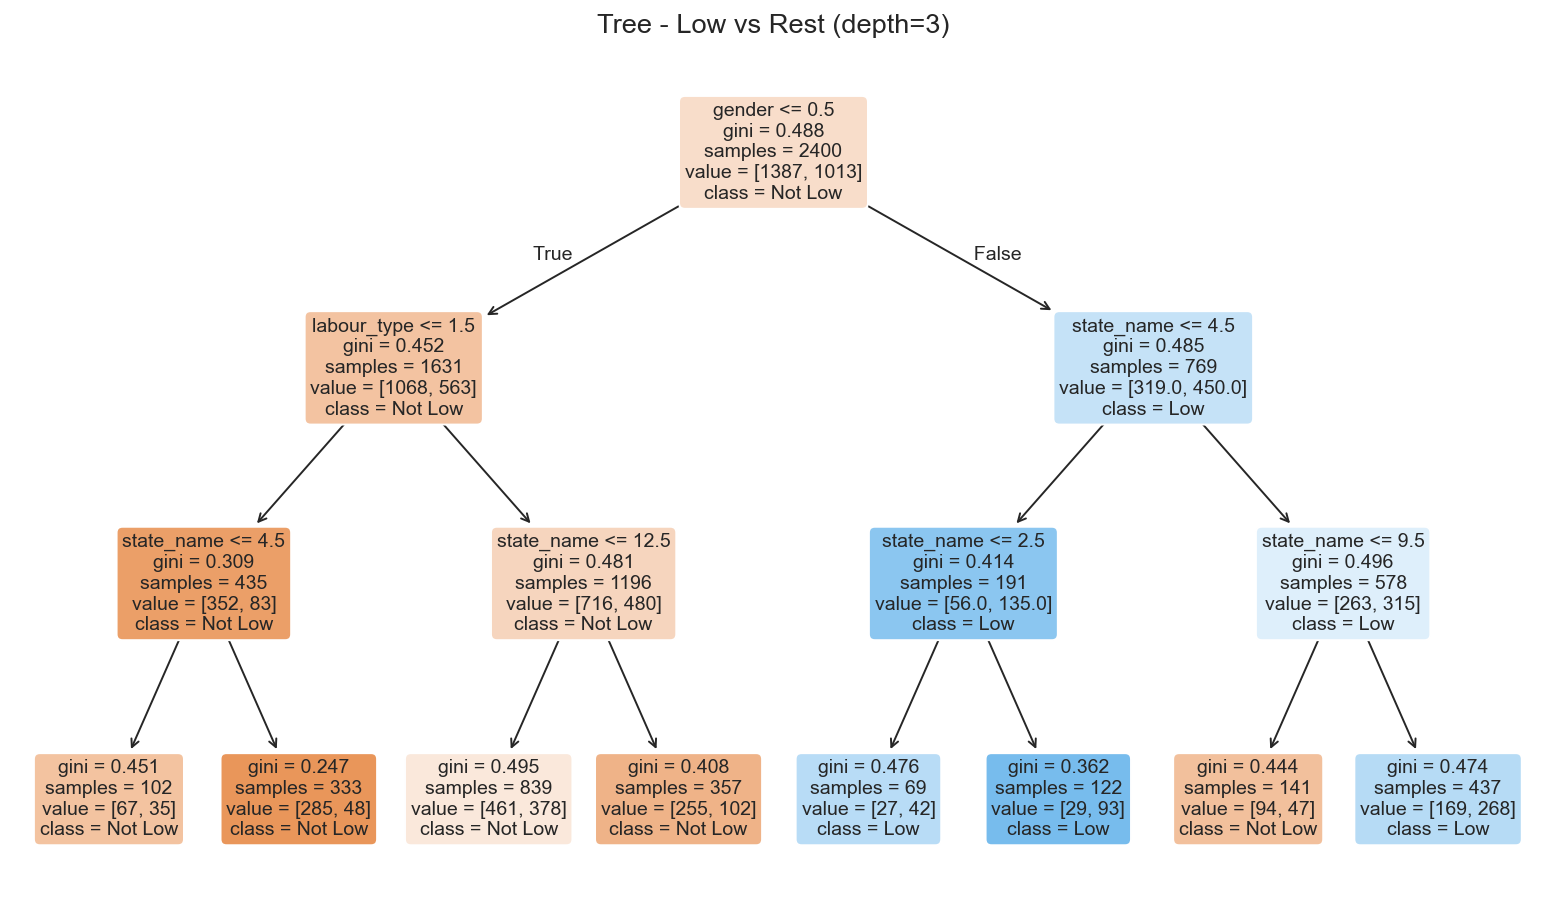


Tree - Low vs Rest — Test Accuracy: 65.50%

Classification Report:
              precision    recall  f1-score   support

     Not Low       0.66      0.82      0.73       347
         Low       0.64      0.42      0.51       253

    accuracy                           0.66       600
   macro avg       0.65      0.62      0.62       600
weighted avg       0.65      0.66      0.64       600



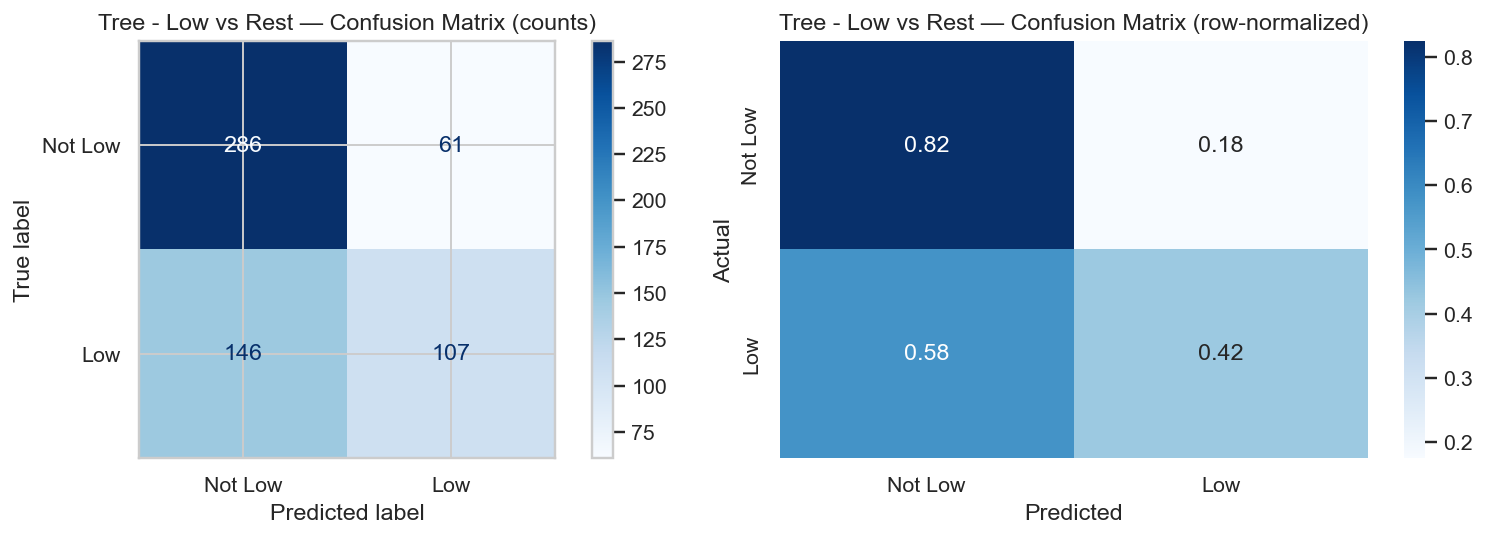

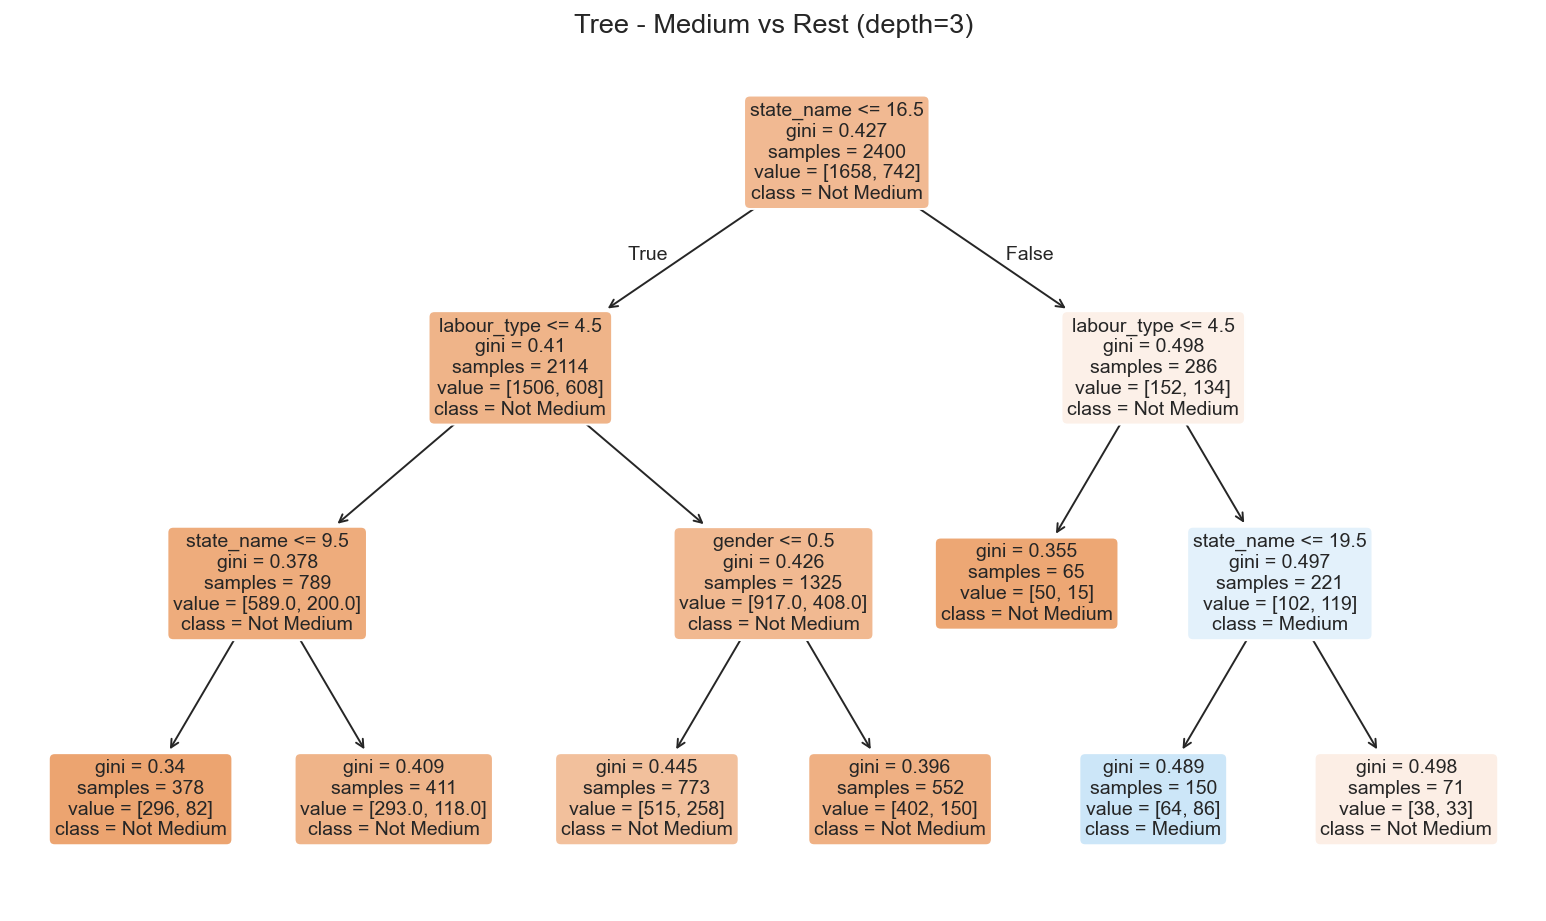


Tree - Medium vs Rest — Test Accuracy: 68.67%

Classification Report:
              precision    recall  f1-score   support

  Not Medium       0.70      0.94      0.81       414
      Medium       0.48      0.11      0.18       186

    accuracy                           0.69       600
   macro avg       0.59      0.53      0.49       600
weighted avg       0.63      0.69      0.61       600



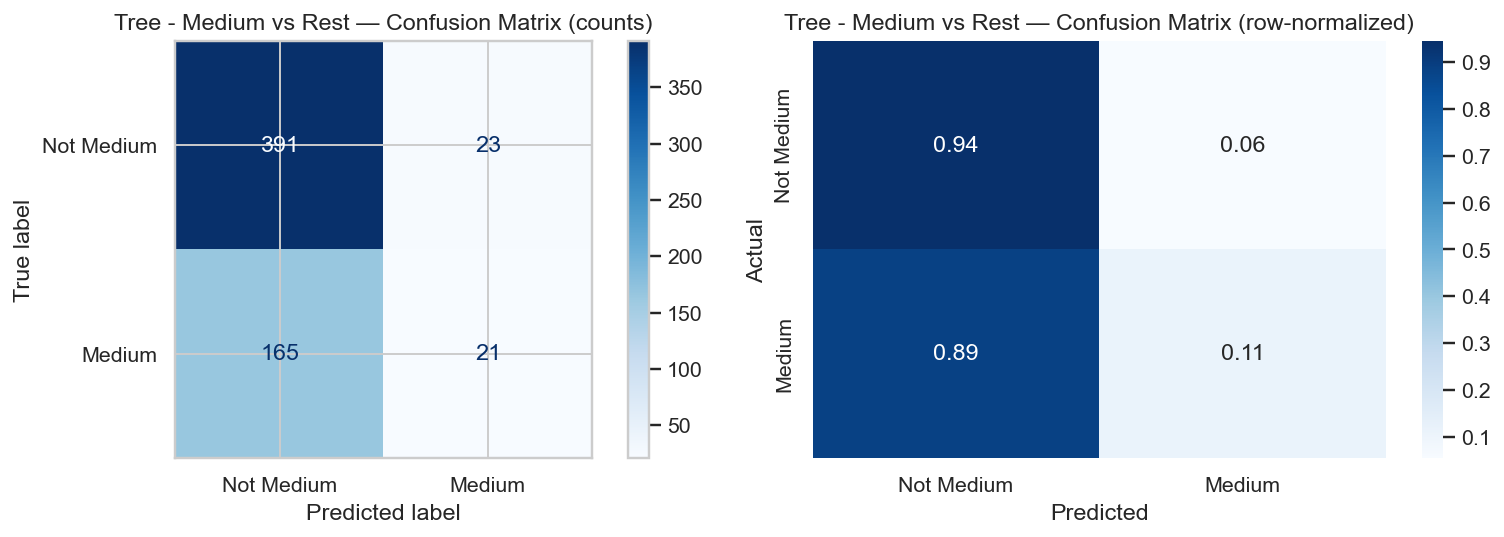


Summary of Decision Tree accuracies:
                   model  accuracy
0    Tree - High vs Rest  0.746667
1  Tree - Medium vs Rest  0.686667
2         Tree - Gujarat  0.673333
3     Tree - Low vs Rest  0.655000
4  Tree - Madhya Pradesh  0.616667
5           Tree - Women  0.571667
6          Tree - Odisha  0.516667
7  Overall Decision Tree  0.515000
8             Tree - Men  0.478333


In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

def train_and_show_tree(X, y, name, features=FEATURES, class_names=None,
                        sample=None, max_depth=MAX_DEPTH, test_size=0.2, random_state=42):
    """
    Train on a train split, show tree, print accuracy + classification report,
    and display confusion matrix on the held-out test set.
    Returns a dict of metrics.
    """
    # sampling for speed/visibility (same as before)
    if sample is not None and len(X) > sample:
        samp_idx = np.random.RandomState(42).choice(X.index, size=sample, replace=False)
        Xs = X.loc[samp_idx]
        ys = y.loc[samp_idx] if isinstance(y, pd.Series) else y[samp_idx]
    else:
        Xs = X
        ys = y

    # Train/test split (stratify if possible)
    try:
        X_tr, X_te, y_tr, y_te = train_test_split(Xs, ys, test_size=test_size,
                                                  random_state=random_state, stratify=ys)
    except Exception:
        X_tr, X_te, y_tr, y_te = train_test_split(Xs, ys, test_size=test_size,
                                                  random_state=random_state)

    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=50, random_state=random_state)
    clf.fit(X_tr, y_tr)

    # Plot tree
    plt.figure(figsize=(14, 8))
    plot_tree(clf, feature_names=features, class_names=class_names, filled=True, rounded=True, fontsize=10)
    plt.title(f"{name} (depth={max_depth})", fontsize=14)
    plt.show()

    # Predict on test set
    y_pred = clf.predict(X_te)

    # Metrics
    acc = accuracy_score(y_te, y_pred)
    print(f"\n{name} — Test Accuracy: {acc*100:.2f}%\n")
    print("Classification Report:")
    print(classification_report(y_te, y_pred, target_names=class_names, zero_division=0))

    # Confusion matrix (counts and normalized)
    cm = confusion_matrix(y_te, y_pred, labels=range(len(class_names)) if all(isinstance(c, str) for c in class_names) else None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    disp.plot(ax=ax[0], cmap="Blues", values_format='d')
    ax[0].set_title(f"{name} — Confusion Matrix (counts)")

    cmn = cm.astype("float") / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
    sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax[1])
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("Actual")
    ax[1].set_title(f"{name} — Confusion Matrix (row-normalized)")
    plt.tight_layout()
    plt.show()

    # Return metrics for comparison
    return {
        "name": name,
        "accuracy": acc,
        "clf": clf,
        "y_test": y_te,
        "y_pred": y_pred,
        "report": classification_report(y_te, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    }

# Example usage: collect metrics for comparison
results = []

# Overall
res = train_and_show_tree(X_all, y_all, "Overall Decision Tree", features=FEATURES, class_names=class_names, sample=SAMPLE_FOR_VIS)
results.append(res)

# Gender-specific
for gender_label in encoders["gender"].classes_:
    code = np.where(encoders["gender"].classes_ == gender_label)[0][0]
    idx = X_all[X_all["gender"] == code].index
    if len(idx) < 100:
        continue
    X_slice = X_all.loc[idx]
    y_slice = y_all.loc[idx]
    res = train_and_show_tree(X_slice, y_slice, f"Tree - {gender_label}", features=FEATURES,
                              class_names=class_names, sample=SAMPLE_FOR_VIS)
    results.append(res)

# State-specific (top 3)
state_counts = df["state_name"].value_counts().head(3)
for state in state_counts.index:
    code = encoders["state_name"].transform([state])[0]
    idx = X_all[X_all["state_name"] == code].index
    if len(idx) < 200:
        continue
    X_slice = X_all.loc[idx]
    y_slice = y_all.loc[idx]
    res = train_and_show_tree(X_slice, y_slice, f"Tree - {state}", features=FEATURES,
                              class_names=class_names, sample=1500)
    results.append(res)

# One-vs-rest (use binary target; class_names given appropriately)
for class_label in class_names:
    binary_y = pd.Series((df["wage_cat"] == class_label).astype(int), index=X_all.index)
    res = train_and_show_tree(X_all, binary_y, f"Tree - {class_label} vs Rest", features=FEATURES,
                              class_names=[f"Not {class_label}", class_label], sample=SAMPLE_FOR_VIS)
    results.append(res)

# Quick summary table of accuracies
summary = pd.DataFrame([{"model": r["name"], "accuracy": r["accuracy"]} for r in results])
print("\nSummary of Decision Tree accuracies:")
print(summary.sort_values("accuracy", ascending=False).reset_index(drop=True))
